# Model

In [1]:
import os, torch

# A100: active TF32 (accelère les matmuls en FP32) + cuDNN autotune
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True

# Sanity checks GPU/bf16
assert torch.cuda.is_available(), "CUDA non dispo"
name = torch.cuda.get_device_name(0)
cap  = torch.cuda.get_device_capability(0)
print(f"[GPU] {name}  CC={cap}, BF16={'OK' if torch.cuda.is_bf16_supported() else 'NO'}")

[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK


In [2]:
import torch
from torch import nn
from typing import Tuple, Dict
import torch
from torch import nn
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

try:
    from mamba_ssm.ops.triton.ssd_combined import mamba_chunk_scan_combined
except Exception:
    mamba_chunk_scan_combined = None

from mamba_ssm import Mamba2

import os
import pickle
import gc
import io
import numpy as np
import pandas as pd
import torch
from torch import nn
from mamba_ssm.modules.mamba_simple import Mamba  # your Mamba
from pytorch_forecasting import TimeSeriesDataSet  # 🔧 FIX 1 – correc--t import
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch.strategies import DDPStrategy

# from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer
from torch.utils.data import DataLoader
from pytorch_forecasting.utils import move_to_device  # ✔ recursive

# Checkpointing and calls
import glob
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from google.cloud import storage
import datetime

# GCS constants
_BUCKET_NAME = "cgmproject2025"
_BASE_PREFIX = "models/predictions"
_gcs_client = storage.Client()


# -------------------------
# Hyperparam presets
# -------------------------
param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

##########Improvement_param#######################

# A100: active TF32 (accelère les matmuls en FP32) + cuDNN autotune
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True

# Sanity checks GPU/bf16
assert torch.cuda.is_available(), "CUDA non dispo"
name = torch.cuda.get_device_name(0)
cap  = torch.cuda.get_device_capability(0)
print(f"[GPU] {name}  CC={cap}, BF16={'OK' if torch.cuda.is_bf16_supported() else 'NO'}")


# =============================
# Utility Functions
# =============================
def log_memory(message=""):
    """Log CPU and GPU memory usage."""
    pid = os.getpid()
    #process = psutil.Process(pid)
    #mem_cpu = process.memory_info().rss / 1e9  # in GB
    if torch.cuda.is_available():
        mem_gpu_allocated = torch.cuda.memory_allocated() / 1e9
        mem_gpu_reserved = torch.cuda.memory_reserved() / 1e9
    else:
        mem_gpu_allocated = mem_gpu_reserved = 0.0
    print(f"[{datetime.datetime.now()}] {message}")
    #print(f"ðŸ§  CPU Mem used: {mem_cpu:.2f} GB")
    print(f"GPU Mem allocated: {mem_gpu_allocated:.2f} GB | reserved: {mem_gpu_reserved:.2f} GB")


def upload_latest_checkpoint_to_gcs(local_dir, bucket_name, gcs_prefix):
    """Upload all .ckpt files in local_dir to GCS under gcs_prefix."""
    bucket = _gcs_client.bucket(bucket_name)
    for file_path in glob.glob(f"{local_dir}/*.ckpt"):
        blob = bucket.blob(f"{gcs_prefix}/{os.path.basename(file_path)}")
        blob.upload_from_filename(file_path)
        print(f"Uploaded {file_path} to gs://{bucket_name}/{gcs_prefix}/")

def download_latest_checkpoint_from_gcs(local_dir, bucket_name, gcs_prefix):
    """Download the latest .ckpt from GCS to local_dir. Returns local path or None."""
    bucket = _gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=gcs_prefix))
    ckpt_blobs = [b for b in blobs if b.name.endswith('.ckpt')]
    if not ckpt_blobs:
        return None
    latest_blob = max(ckpt_blobs, key=lambda b: b.updated)
    local_path = os.path.join(local_dir, os.path.basename(latest_blob.name))
    latest_blob.download_to_filename(local_path)
    print(f"Downloaded {latest_blob.name} to {local_path}")
    return local_path


# -------------------------
# Blocs Mamba MES
# -------------------------

class Mamba2MESIdentical(Mamba2):
    """
    Mamba-2 en mode MES identique train/inférence:
      - Chemin non-fused (même code path).
      - VRAI MES : B par tête, C et X partagés entre têtes.
      - Compat A_log: (H,) ou (N,) ou (G*N,) ou (G,N)
      - Compat D: (H,P) ou (H,) ou (P,) ou scalaire; passé par tête au kernel.

    get_saved_internals() -> (dt_raw: B,H,L; A_log: H,G*N; B_in_h: B,H,G*N,L; C_in: B,G*N,L)
    """

    def __init__(
        self, *args,
        mes_diag: bool = True,
        record_default: bool = False,
        save_to_cpu: bool = False,
        debug_kernel_shapes: bool = False, #True,
        x_share_mode: str = "mean",  # "mean" (par défaut) ou "first"
        **kwargs
    ):
        # forcer chemin non-fused
        kwargs = {**kwargs, "use_mem_eff_path": False}
        super().__init__(*args, **kwargs)

        if mamba_chunk_scan_combined is None:
            raise RuntimeError("mamba_chunk_scan_combined introuvable (installe les ops Triton mamba-ssm).")

        self._record = bool(record_default)
        self._save_to_cpu = bool(save_to_cpu)
        self._saved_hidden = None
        self._debug_once = bool(debug_kernel_shapes)  # imprime les shapes une fois
        self.x_share_mode = str(x_share_mode)

        # --- MES params: B par tête ---
        N_total = self.ngroups * self.d_state
        self.mes_diag = bool(mes_diag)
        if self.mes_diag:
            self.B_head_scale = nn.Parameter(torch.ones(self.nheads, N_total))  # (H, G*N)
        else:
            self.B_head_mix = nn.Parameter(torch.zeros(self.nheads, N_total, N_total))  # (H, G*N, G*N)
            with torch.no_grad():
                for h in range(self.nheads):
                    self.B_head_mix[h].zero_()
                    self.B_head_mix[h].diagonal().fill_(1.0)

        # compat attributs suivant versions
        if not hasattr(self, "learnable_init_states"):
            self.learnable_init_states = False
        if not hasattr(self, "init_states"):
            self.init_states = None
        if not hasattr(self, "dt_limit"):
            self.dt_limit = (0.0, float("inf"))

        # garde-fou headdim
        assert (self.d_inner % self.headdim) == 0, \
            f"d_inner={self.d_inner} doit être divisible par headdim={self.headdim}"

    def set_record(self, on: bool = True):
        self._record = bool(on)

    def set_debug(self, on: bool = True):
        self._debug_once = bool(on)

    def get_saved_internals(self):
        return self._saved_hidden

    def _normalize_A(self):
        """Retourne (mode, A_head, A_scan) avec:
           - mode='per_head' -> A_head: (H,), A_scan=None
           - mode='per_state'-> A_head=None, A_scan: (G,N)
        """
        A_raw = self.A_log
        H, G, N = self.nheads, self.ngroups, self.d_state
        GN = G * N

        if A_raw.numel() == H:
            return "per_head", (-torch.exp(A_raw)).contiguous(), None
        elif A_raw.numel() == N:
            A_scan = (-torch.exp(A_raw)).view(1, N).expand(G, -1).contiguous()
            return "per_state", None, A_scan
        elif A_raw.numel() == GN:
            A_scan = (-torch.exp(A_raw)).view(G, N).contiguous()
            return "per_state", None, A_scan
        else:
            raise RuntimeError(
                f"A_log shape inattendue: {tuple(A_raw.shape)} ; "
                f"attendu H={H} ou N={N} ou G*N={GN}"
            )

    def _normalize_D(self, device, dtype):
        """Normalise self.D pour obtenir D_scan:
           - si None -> None
           - sinon -> (H,P) ou (H,), dtype/device ok
        """
        if not hasattr(self, "D") or self.D is None:
            return None

        D_raw = self.D
        if not isinstance(D_raw, torch.Tensor):
            D_raw = torch.as_tensor(D_raw)
        D_raw = D_raw.to(device=device, dtype=dtype)

        H, P = self.nheads, self.headdim
        if D_raw.dim() == 0:
            # scalaire -> (H,P)
            return D_raw.view(1, 1).expand(H, P).contiguous()
        if D_raw.dim() == 1:
            if D_raw.numel() == H:
                return D_raw.contiguous()  # (H,)
            if D_raw.numel() == P:
                return D_raw.view(1, P).expand(H, -1).contiguous()  # (H,P)
            if D_raw.numel() == self.d_inner:
                return D_raw.view(H, P).contiguous()  # (H,P)
            # fallback si possible
            if (D_raw.numel() % P) == 0 and (D_raw.numel() // P) == H:
                return D_raw.view(H, P).contiguous()
            raise RuntimeError(f"D shape inattendue (1D): {tuple(D_raw.shape)}")
        if D_raw.dim() == 2:
            if D_raw.shape == (H, P) or D_raw.shape == (H,):
                return D_raw.contiguous()
            if D_raw.shape == (P, H):
                return D_raw.t().contiguous()
            if D_raw.numel() == self.d_inner:
                return D_raw.reshape(H, P).contiguous()
            raise RuntimeError(f"D shape inattendue (2D): {tuple(D_raw.shape)}")
        raise RuntimeError(f"D dim inattendue: {D_raw.dim()}")

    def forward(self, u: torch.Tensor, seq_idx=None):
        """
        u: (B, L, D_model)
        """
        Bsz, seqlen, _ = u.shape

        # (1) in-proj -> [z, xBC, dt]
        zxbcdt = self.in_proj(u)
        z, xBC, dt = torch.split(
            zxbcdt,
            [self.d_inner,
             self.d_inner + 2 * self.ngroups * self.d_state,
             self.nheads],
            dim=-1,
        )

        # (2) dt raw & pos (par tête)
        dt_raw = dt + self.dt_bias            # (B, L, H)
        dt_pos = F.softplus(dt_raw)           # (B, L, H)

        # (3) conv1d + SiLU sur xBC
        xBC = F.silu(self.conv1d(xBC.transpose(1, 2)).transpose(1, 2))
        xBC = xBC[:, :seqlen, :]

        # (4) split -> x, B_shared, C_shared
        x, B_shared, C_shared = torch.split(
            xBC,
            [self.d_inner,
             self.ngroups * self.d_state,
             self.ngroups * self.d_state],
            dim=-1,
        )

        # (5) construire B_h (B par tête)
        if self.mes_diag:
            B_h = B_shared.unsqueeze(2) * self.B_head_scale.unsqueeze(0).unsqueeze(0)  # (B,L,H,GN)
        else:
            B_h = torch.einsum("hnm,blm->blhn", self.B_head_mix, B_shared)             # (B,L,H,GN)

        # (6) préparer pour scan
        # MES strict: X partagé entre têtes (même entrée x pour toutes les têtes)
        x_heads  = rearrange(x, "b l (h p) -> b l h p", p=self.headdim).contiguous()   # (B,L,H,P)
        if self.x_share_mode == "mean":
            x_shared = x_heads.mean(dim=2, keepdim=True).contiguous()                 # (B,L,1,P)
        elif self.x_share_mode == "first":
            x_shared = x_heads[:, :, :1, :].contiguous()                               # (B,L,1,P)
        else:
            raise ValueError("x_share_mode doit être 'mean' ou 'first'")
        C_scan   = rearrange(C_shared, "b l (g n) -> b l g n", g=self.ngroups).contiguous()   # (B,L,G,N)

        # A & D normalisés
        A_mode, A_head, A_scan = self._normalize_A()
        D_scan = self._normalize_D(device=x.device, dtype=x.dtype)  # (H,P) ou (H,) ou None

        # kwargs communs (sans D ici !)
        initial_states = self.init_states if self.learnable_init_states else None
        scan_common = dict(
            chunk_size=self.chunk_size,
            z=None,
            seq_idx=seq_idx,
            initial_states=initial_states,
        )
        if self.dt_limit != (0.0, float("inf")):
            scan_common["dt_limit"] = self.dt_limit

        # debug (une seule fois)
        if self._debug_once:
            print("[Mamba2MES] DEBUG SHAPES")
            #print("  u:", tuple(u.shape))
            #print("  x_heads:", tuple(x_heads.shape), "x_shared:", tuple(x_shared.shape))
            #print("  dt_raw:", tuple(dt_raw.shape), "dt_pos:", tuple(dt_pos.shape))
            #print("  B_h:", tuple(B_h.shape), "C_scan:", tuple(C_scan.shape))
            #print("  headdim:", self.headdim, "nheads:", self.nheads,
            #      "ngroups:", self.ngroups, "d_state:", self.d_state)
            if A_mode == "per_head":
                print("  A_mode: per_head ; A_head:", tuple(A_head.shape))
            else:
                print("  A_mode: per_state ; A_scan:", tuple(A_scan.shape))
            if D_scan is None:
                print("  D: None")
            else:
                if D_scan.dim() == 2:
                    print("  D_scan:", tuple(D_scan.shape), "(H,P)")
                else:
                    print("  D_scan:", tuple(D_scan.shape), "(H,)")

        y_heads = []
        for h in range(self.nheads):
            B_scan_h = rearrange(B_h[:, :, h, :], "b l (g n) -> b l g n", g=self.ngroups).contiguous()  # (B,L,G,N)

            # A par appel
            if A_mode == "per_state":
                A_arg = A_scan                               # (G,N)
            else:
                A_arg = A_head[h:h+1].contiguous()           # (1,)

            # D par appel (IMPORTANT: nheads=1 attendu par le kernel sur cet appel)
            if D_scan is None:
                D_arg = None
            else:
                if D_scan.dim() == 2:
                    D_arg = D_scan[h:h+1, :].contiguous()    # (1,P)
                else:
                    D_arg = D_scan[h:h+1].contiguous()       # (1,)

            # debug par-tête (première tête uniquement)
            if h == 0 and self._debug_once:
                print("  [per-head example] x:", tuple(x_shared.shape),
                      "dt:", tuple(dt_pos[:, :, h:h+1].shape),
                      "A:", (tuple(A_arg.shape) if isinstance(A_arg, torch.Tensor) else None),
                      "B:", tuple(B_scan_h.shape),
                      "C:", tuple(C_scan.shape),
                      "D:", (tuple(D_arg.shape) if isinstance(D_arg, torch.Tensor) else None))
                # couper le debug après le 1er exemple pour éviter le spam
                self._debug_once = False

            y_h = mamba_chunk_scan_combined(
                x_shared,                               # (B,L,1,P) -> X partagé
                dt_pos[:, :, h:h+1].contiguous(),      # (B,L,1)
                A_arg,                                  # (G,N) ou (1,)
                B_scan_h,                               # (B,L,G,N)
                C_scan,                                 # (B,L,G,N)
                D=D_arg,                                # (1,P) ou (1,) ou None
                **scan_common,
            )  # -> (B,L,1,P)
            y_heads.append(y_h)

        y = torch.cat(y_heads, dim=2)                         # (B,L,H,P)
        y = rearrange(y, "b l h p -> b l (h p)").contiguous() # (B,L,d_inner)

        # (7) gating+norm + out-proj
        y = self.norm(y, z)
        out = self.out_proj(y)

        # (8) enregistrement optionnel
        if self._record:
            dt_save = rearrange(dt_raw, "b l h -> b h l").detach()  # (B,H,L)
            G, N, H = self.ngroups, self.d_state, self.nheads
            GN = G * N
            if A_mode == "per_state":
                A_states_log = self.A_log
                if A_states_log.numel() == N:
                    A_states_log = A_states_log.view(1, N).expand(G, -1)  # (G,N)
                else:
                    A_states_log = A_states_log.view(G, N)                # (G,N)
                A_log_exp = A_states_log.reshape(1, GN).expand(H, -1).contiguous().detach()  # (H,GN)
            else:
                A_log_exp = self.A_log.view(H, 1).expand(H, GN).contiguous().detach()       # (H,GN)

            B_in_h = rearrange(B_h, "b l h n -> b h n l").detach()   # (B,H,GN,L)
            C_in   = rearrange(C_shared, "b l n -> b n l").detach()  # (B,GN,L)

            if self._save_to_cpu:
                dt_save = dt_save.cpu(); A_log_exp = A_log_exp.cpu()
                B_in_h = B_in_h.cpu();   C_in = C_in.cpu()

            self._saved_hidden = (dt_save, A_log_exp, B_in_h, C_in)

        return out



class ResidualMambaBlock(nn.Module):
    def __init__(
        self,
        d_model: int,
        dropout: float = 0.1,
        checkpoint: bool = False,
        return_hidden_attn: bool = False,
        # Hyperparams Mamba-2 "plats"
        d_state: int = 64,
        d_conv: int = 4,
        expand: int = 4, # combien de fois le hidden size
        headdim: int = 128,
        ngroups: int = 2,
        # compat: on ignore dt_rank s’il est passé par erreur
        dt_rank: int | None = None,
    ):
        # d_inner = expand*d_model
        # self.nheads = self.d_inner // self.headdim
        # d_model = hidden_size


        super().__init__()
        self.norm = nn.LayerNorm(d_model)

        self.mamba = Mamba2MESIdentical(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
            headdim=headdim,
            ngroups=ngroups,
            record_default=return_hidden_attn,
        )
        self.drop = nn.Dropout(dropout)
        self.checkpoint = checkpoint

    def _forward_inner(self, x: torch.Tensor) -> torch.Tensor:
        y = self.mamba(self.norm(x))
        return x + self.drop(y)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.checkpoint and self.training:
            return torch.utils.checkpoint.checkpoint(self._forward_inner, x, use_reentrant=False)
        return self._forward_inner(x)


class StackedMamba(nn.Module):
    def __init__(
        self,
        d_model: int,
        depth: int = 4,
        dropout: float = 0.1,
        checkpoint: bool = False,
        return_hidden_attn: bool = False,
        d_state: int = 64,
        d_conv: int = 4,
        expand: int = 4,
        headdim: int = 128,
        ngroups: int = 1,
        dt_rank: int | None = None,  # ignoré
    ):
        super().__init__()
        self.blocks = nn.ModuleList([
            ResidualMambaBlock(
                d_model=d_model,
                dropout=dropout,
                checkpoint=checkpoint,
                return_hidden_attn=return_hidden_attn,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
                headdim=headdim,
                ngroups=ngroups,
                dt_rank=dt_rank,
            )
            for _ in range(depth)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for blk in self.blocks:
            x = blk(x)
        return x


class DummyMambaAttn(nn.Module):
    """Remplace la MultiHeadAttention TFT par un petit mixeur Mamba sur q seulement.
    Renvoie des poids d'attention nuls pour préserver l'API & l'interprétabilité.
    """

    def __init__(
        self, d_model: int, n_head: int = 2, depth: int = 1, dropout: float = 0.0, return_hidden_attn = False
    ):
        super().__init__()
        self.n_head = n_head
        self.mixer = StackedMamba(d_model=d_model, depth=depth, dropout=dropout, return_hidden_attn=return_hidden_attn)

    def forward(self, q, k=None, v=None, mask=None):
        out = self.mixer(q)  # (B, L_q, D)
        B, L_q, _ = q.shape
        L_k = k.size(1) if k is not None else L_q
        attn = q.new_zeros(B, self.n_head, L_q, L_k)  # dummy weights
        # (Optionnel) appliquer mask => attn.masked_fill_(mask, 0.) si tu veux quelque chose de cohérent
        return out, attn


# ---------------------------------------------------------------------
# MambaTFT
# ---------------------------------------------------------------------
class MambaTFT(TemporalFusionTransformer):
    def __init__(
        self,
        *args,
        mamba_depth: int = 4,
        mamba_dropout: float = 0.1,
        mamba_checkpoint: bool = False,
        mamba_block_config: dict | None = None,   # 👈 ajouté
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        del self.lstm_encoder  
        del self.lstm_decoder
        del self.multihead_attn
        del self.static_context_initial_cell_lstm
        del self.static_context_initial_hidden_lstm
        # ... (suppression LSTM/MHA inchangée)

        d_model = self.hparams.hidden_size
        mb = mamba_block_config or {}

        self.lstm_encoder = StackedMamba(
            d_model=d_model,
            depth=mamba_depth,
            dropout=mamba_dropout,
            checkpoint=mamba_checkpoint,
            # 👇 tire les HP bloc depuis la config
            d_state=mb.get("d_state", 64),
            d_conv=mb.get("d_conv", 4),
            expand=mb.get("expand", 4),
            headdim=mb.get("headdim", 128),
            ngroups=mb.get("ngroups", 1),
            return_hidden_attn=mb.get("return_hidden_attn", False),
        )
        self.lstm_decoder = nn.Identity()

        self.multihead_attn = DummyMambaAttn(
            d_model=d_model,
            n_head=self.hparams.attention_head_size,
            dropout=mamba_dropout,
        )

    # ------------------------------------------------------------------
    # On ne touche qu'à la partie LSTM/attention, le reste reste identique.
    # ------------------------------------------------------------------
    def forward(self, x: Dict[str, torch.Tensor]):
        encoder_lengths = x["encoder_lengths"]
        decoder_lengths = x["decoder_lengths"]
        total_lengths = encoder_lengths + decoder_lengths

        x_cat = torch.cat([x["encoder_cat"], x["decoder_cat"]], dim=1)
        x_cont = torch.cat([x["encoder_cont"], x["decoder_cont"]], dim=1)
        timesteps = x_cont.size(1)  # L_enc + L_dec
        max_encoder_length = int(encoder_lengths.max())

        # ==== 1) Embedding & variable selection (unchanged) =============
        input_vectors = self.input_embeddings(x_cat)
        input_vectors.update(
            {
                name: x_cont[..., idx].unsqueeze(-1)
                for idx, name in enumerate(self.hparams.x_reals)
                if name in self.reals
            }
        )
        if len(self.static_variables) > 0:
            static_embedding_src = {
                name: input_vectors[name][:, 0] for name in self.static_variables
            }
            static_embedding, static_variable_selection = (
                self.static_variable_selection(static_embedding_src)
            )
        else:
            static_embedding = torch.zeros(
                (x_cont.size(0), self.hparams.hidden_size),
                dtype=self.dtype,
                device=self.device,
            )
            static_variable_selection = torch.zeros(
                (x_cont.size(0), 0), dtype=self.dtype, device=self.device
            )
        static_context_varsel = self.expand_static_context(
            self.static_context_variable_selection(static_embedding), timesteps
        )
        embeddings_varying_encoder = {
            n: input_vectors[n][:, :max_encoder_length] for n in self.encoder_variables
        }
        embeddings_varying_encoder, encoder_sparse_weights = (
            self.encoder_variable_selection(
                embeddings_varying_encoder,
                static_context_varsel[:, :max_encoder_length],
            )
        )
        embeddings_varying_decoder = {
            n: input_vectors[n][:, max_encoder_length:] for n in self.decoder_variables
        }
        embeddings_varying_decoder, decoder_sparse_weights = (
            self.decoder_variable_selection(
                embeddings_varying_decoder,
                static_context_varsel[:, max_encoder_length:],
            )
        )

        # ==== 2) Mamba sur toute la fenêtre =============================
        embeddings_full = torch.cat(
            [embeddings_varying_encoder, embeddings_varying_decoder], dim=1
        )  # (B, L, D)
        full_seq = self.lstm_encoder(embeddings_full)  # (B, L, D)

        encoder_output = full_seq[:, :max_encoder_length]
        decoder_output = full_seq[:, max_encoder_length:]
        #h, c = _last_step_summary(full_seq, total_lengths)

        # ==== 3) Skip connection & gating (inchangé) ====================
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(
            lstm_output_encoder, embeddings_varying_encoder
        )
        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(
            lstm_output_decoder, embeddings_varying_decoder
        )
        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)

        # ==== 4) Static enrichment & pseudo-attention ===================
        static_context_enrich = self.static_context_enrichment(static_embedding)
        attn_input = self.static_enrichment(
            lstm_output, self.expand_static_context(static_context_enrich, timesteps)
        )

        attn_output, attn_output_weights = self.multihead_attn(
            q=attn_input,
            k=attn_input,
            v=attn_input,
            mask=self.get_attention_mask(
                encoder_lengths=encoder_lengths, decoder_lengths=decoder_lengths
            ),
        )

        attn_output = attn_output[:, max_encoder_length:]

        
        attn_output = self.post_attn_gate_norm(
            attn_output, attn_input[:, max_encoder_length:]
        )

        # ==== 5) Position‑wise FF & output head ========================
        output = self.pos_wise_ff(attn_output)
        output = self.pre_output_gate_norm(output, lstm_output[:, max_encoder_length:])
        if self.n_targets > 1:
            output = [layer(output) for layer in self.output_layer]
        else:
            output = self.output_layer(output)

        return self.to_network_output(
            prediction=self.transform_output(output, target_scale=x["target_scale"]),
            encoder_attention=attn_output_weights[..., :max_encoder_length],
            decoder_attention=attn_output_weights[..., max_encoder_length:],
            static_variables=static_variable_selection,
            encoder_variables=encoder_sparse_weights,
            decoder_variables=decoder_sparse_weights,
            decoder_lengths=decoder_lengths,
            encoder_lengths=encoder_lengths,
        )

def create_tft_dataloaders(train_df, horizon=12, context_length=72, batchsize=32):
    log_memory("🚀 Start of Dataloader Creation")

    # --- Extra Variables Outside Main Timeseries ---
    static_categoricals = [
        "participant_id",
        "clinical_site",
        "study_group",
    ]  # Have info on participant
    static_reals = ["age"]

    time_varying_known_categoricals = ["sleep_stage"]
    time_varying_known_reals = [
        "ds",
        "minute_of_day",
        "tod_sin",
        "tod_cos",
        "activity_steps",
        "calories_value",
        "heartrate",
        "oxygen_saturation",
        "respiration_rate",
        "stress_level",
        "predmeal_flag",
    ]  # To ensure time index (ordering is met)
    time_varying_unknown_reals = [
        "cgm_glucose",
        "cgm_lag_1",
        "cgm_lag_3",
        "cgm_lag_6",
        "cgm_diff_lag_1",
        "cgm_diff_lag_3",
        "cgm_diff_lag_6",
        "cgm_lagdiff_1_3",
        "cgm_lagdiff_3_6",
        "cgm_rolling_mean",
        "cgm_rolling_std",
    ]

    # --- Découpe temporelle ---
    # max_date = train_df["ds"].max()
    # cut_off_date = max_date - pd.Timedelta(days=context_length)

    # horizon = 12  # Predict 12 steps (1 hour)
    cut_off_date = train_df["ds"].max() - horizon  # Use latest horizon

    # --- Création du TimeSeriesDataSet ---
    training = TimeSeriesDataSet(
        train_df[train_df["ds"] < cut_off_date],
        time_idx="ds",
        target="cgm_glucose",
        group_ids=["participant_id"],
        max_encoder_length=context_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_categoricals=time_varying_known_categoricals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=["participant_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = training.from_dataset(
        training, train_df, predict=True, stop_randomization=True
    )

    # --- Dataloaders ---
    train_dataloader = training.to_dataloader(
        train=True,
        batch_size=batchsize,
        persistent_workers=False,
        num_workers=1,
        pin_memory=False, # CHANGE TO REDUCE MOMORY USAGE
    )
    val_dataloader = validation.to_dataloader(
        train=False,
        batch_size=batchsize,
        num_workers=0,
        persistent_workers=False,
        pin_memory=False,
    )


    return training, val_dataloader, train_dataloader, validation

# =============================
# Model Training
# =============================
class FirstEpochTimer(pl.Callback):
    def __init__(self, local_path, gcs_bucket, gcs_prefix):
        super().__init__()
        self.local_path = local_path
        self.gcs_bucket = gcs_bucket
        self.gcs_prefix = gcs_prefix
        self.start_time = None
        self.logged = False

    def on_train_epoch_start(self, trainer, pl_module):
        # always record, not just epoch 0
        self.start_time = datetime.datetime.now()

    def on_train_epoch_end(self, trainer, pl_module):
        # only log+upload once, still guarding with `self.logged`
        if not self.logged:
            end_time = datetime.datetime.now()
            elapsed = (end_time - self.start_time).total_seconds()
            with open(self.local_path, 'w') as f:
                f.write(f"first_epoch_runtime_seconds: {elapsed}\n")
            # Upload to GCS
            bucket = _gcs_client.bucket(self.gcs_bucket)
            blob = bucket.blob(f"{self.gcs_prefix}/first_epoch_runtime.txt")
            blob.upload_from_filename(self.local_path)
            print(f"Uploaded first epoch runtime to gs://{self.gcs_bucket}/{self.gcs_prefix}/first_epoch_runtime.txt")
            self.logged = True

class GCSCheckpointUploader(pl.Callback):
    def __init__(self, local_dir, bucket_name, gcs_prefix):
        super().__init__()
        self.local_dir = local_dir
        self.bucket_name = bucket_name
        self.gcs_prefix = gcs_prefix
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        # This hook is called after a checkpoint is saved
        upload_latest_checkpoint_to_gcs(self.local_dir, self.bucket_name, self.gcs_prefix)

class GCSLossLogger(pl.Callback):
    def __init__(self, log_path, bucket_name, gcs_prefix, log_every_n_batches=5000):
        super().__init__()
        self.log_path = log_path
        self.bucket_name = bucket_name
        self.gcs_prefix = gcs_prefix
        self.log_every_n_batches = log_every_n_batches
        self.batch_count = 0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        self.batch_count += 1
        # Try to extract loss from outputs
        loss = None
        if isinstance(outputs, dict) and 'loss' in outputs:
            loss = outputs['loss'].item()
        elif hasattr(outputs, 'item'):
            loss = outputs.item()
        if self.batch_count % self.log_every_n_batches == 0 and loss is not None:
            with open(self.log_path, 'a') as f:
                f.write(f"Batch {self.batch_count}: loss={loss}\n")
            # Upload to GCS
            bucket = _gcs_client.bucket(self.bucket_name)
            blob = bucket.blob(f"{self.gcs_prefix}/loss_log.txt")
            blob.upload_from_filename(self.log_path)
            print(f"Uploaded loss log to gs://{self.bucket_name}/{self.gcs_prefix}/loss_log.txt")

def download_last_ckpt(local_dir: str, bucket_name: str, gcs_prefix: str):
    os.makedirs(local_dir, exist_ok=True)
    bucket = _gcs_client.bucket(bucket_name)
    blob = bucket.blob(f"{gcs_prefix}/last.ckpt")
    if blob.exists():
        local_path = os.path.join(local_dir, "last.ckpt")
        blob.download_to_filename(local_path)
        print(f"Downloaded {blob.name} to {local_path}")
        return local_path
    return None

def TFT_train(train_df, param):
    # === tire les configs du preset ===
    ds_cfg = param["dataset"]
    mb_cfg = param["mamba_block"]
    mt_cfg = param["mamba_tft_init"]

    # heads = (expand * d_model) // headdim
    attention_heads = (mb_cfg["expand"] * mb_cfg["d_model"]) // mb_cfg["headdim"]

    horizon = ds_cfg["horizon"]
    context_length = ds_cfg["context_length"]
    batchsize = ds_cfg["batch_size"]

    log_memory("🚀 Début du chargement des dataloaders")

    training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(
        train_df, horizon=horizon, context_length=context_length, batchsize=batchsize
    )

    del train_df
    gc.collect()
    log_memory("First creation of dataloaders")

    loss = QuantileLoss(quantiles=[0.1, 0.5, 0.9])

    # === MambaTFT.from_dataset avec HP issus de param ===
    tft = MambaTFT.from_dataset(
        training,
        learning_rate=0.001,                    # garde ta LR (ou mets-la aussi dans param si tu veux)
        hidden_size=mb_cfg["d_model"],          # 👈 d_model du bloc
        attention_head_size=attention_heads,    # 👈 cohérent avec expand/headdim
        dropout=mt_cfg["mamba_dropout"],        # 👈 dropout global TFT
        loss=loss,
        log_interval=10,
        log_val_interval=1,
        reduce_on_plateau_patience=4,
        # 👇 hyperparams spécifiques Mamba passés au __init__
        mamba_depth=mt_cfg["mamba_depth"],
        mamba_dropout=mt_cfg["mamba_dropout"],
        mamba_checkpoint=False,
        mamba_block_config=mb_cfg,
    )

    ###############
    # Checkpointing and Callbacks
    ###############
    log_memory("Model creation before training")
    # --- ModelCheckpoint callback ---
    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="mamba576_MES-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        monitor="val_loss",
        mode="min",
        save_last=True,
        save_on_train_epoch_end=True
    )
    # --- First epoch timer callback ---
    first_epoch_timer = FirstEpochTimer(
        local_path="first_epoch_runtime.txt",
        gcs_bucket=_BUCKET_NAME,
        gcs_prefix="checkpoints_mamba576_MESv2"
    )
    # --- GCS checkpoint uploader callback ---
    gcs_ckpt_prefix = "checkpoints_mamba576_MESv2"
    gcs_checkpoint_uploader = GCSCheckpointUploader(
        local_dir="checkpoints",
        bucket_name=_BUCKET_NAME,
        gcs_prefix=gcs_ckpt_prefix
    )
    # --- GCS loss logger callback ---
    gcs_loss_logger = GCSLossLogger(
        log_path="loss_log.txt",
        bucket_name=_BUCKET_NAME,
        gcs_prefix=gcs_ckpt_prefix,
        log_every_n_batches=5000
    )
    # --- Download latest checkpoint from GCS if exists ---
    os.makedirs("checkpoints", exist_ok=True)
    ckpt_path = download_last_ckpt("checkpoints", _BUCKET_NAME, gcs_ckpt_prefix)
    # log what happened
    if ckpt_path:
        print(f"[INFO] Resuming from checkpoint: {ckpt_path}")
    else:
        print("[INFO] No checkpoint found: starting fresh")


    # === régler le runtime MES à partir du preset ===
    rt = param["mamba2_mes_runtime"]
    for blk in tft.lstm_encoder.blocks:
        blk.mamba.chunk_size = rt["chunk_size"]
        blk.mamba.dt_limit = rt["dt_limit"]
        blk.mamba.learnable_init_states = rt["learnable_init_states"]
        blk.mamba.set_debug(False)
        if rt.get("D", None) is not None:
            blk.mamba.D = rt["D"]

    # désactive la collecte pendant l'entraînement
    for blk in tft.lstm_encoder.blocks:
        blk.mamba.return_hidden_attn = False
    tft.lstm_encoder.return_hidden_attn = False

    log_memory("Model Creations before training")

    trainer = Trainer(
        max_epochs=30,
        gradient_clip_val=1.0,
        val_check_interval=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=15, mode="min"),
            #LearningRateMonitor(logging_interval="epoch"),
            checkpoint_callback,
            first_epoch_timer,
            gcs_checkpoint_uploader,
            gcs_loss_logger,
        ],
        enable_progress_bar=False,            # was True; disable to prevent large log entries
        enable_model_summary=False,           # suppress big model summary block
        logger=False,                         # rely on custom GCS logging
        #enable_progress_bar=True,
        accelerator="gpu",
        devices=4,
        strategy="ddp", #"ddp",
    )
    log_memory("Before training")
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=ckpt_path)
    log_memory("End training")

    return tft, trainer, val_dataloader, train_dataloader, validation, training

# =============================
# Model Save/Load Utilities
# =============================
def save_tft_to_gcs(
    tft: TemporalFusionTransformer,
    model_name: str = "default_model",
    bucket_name: str = _BUCKET_NAME,
    prefix: str = _BASE_PREFIX,
):
    """Save TFT state_dict and hyperparams to GCS."""
    bucket = _gcs_client.bucket(bucket_name)
    model_prefix = f"{prefix}/{model_name}"
    buf = io.BytesIO()
    torch.save(tft.state_dict(), buf)
    buf.seek(0)
    blob = bucket.blob(f"{model_prefix}/model.pth")
    blob.upload_from_file(buf)
    buf.close()
    buf = io.BytesIO()
    pickle.dump(tft.hparams, buf)
    buf.seek(0)
    blob = bucket.blob(f"{model_prefix}/model_kwargs.pkl")
    blob.upload_from_file(buf)
    buf.close()
    print(f"Model artifacts uploaded to gs://{bucket_name}/{model_prefix}/")

def load_tft_from_gcs(
    training_dataset,
    model_name: str = "default_model",
    map_location=None,
    bucket_name: str = _BUCKET_NAME,
    prefix: str = _BASE_PREFIX,
) -> MambaTFT:
    """Fetch model_kwargs.pkl and model.pth from GCS, rebuild the TFT, load weights, and return it."""
    if map_location is None:
        map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bucket = _gcs_client.bucket(bucket_name)
    model_prefix = f"{prefix}/{model_name}"
    blob = bucket.blob(f"{model_prefix}/model_kwargs.pkl")
    hparams_bytes = blob.download_as_bytes()
    model_kwargs = pickle.loads(hparams_bytes)
    tft = MambaTFT.from_dataset(training_dataset, **model_kwargs)
    blob = bucket.blob(f"{model_prefix}/model.pth")
    state_bytes = blob.download_as_bytes()
    buf = io.BytesIO(state_bytes)
    state_dict = torch.load(buf, map_location=map_location)
    tft.load_state_dict(state_dict)
    buf.close()
    print(f"Loaded TFT from gs://{bucket_name}/{model_prefix}/")
    return tft

/home/yentlcollin/miniconda3/envs/mambatf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/yentlcollin/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yentlcollin/miniconda3/envs/mambatf/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK


In [3]:
# Print rank and GPU info
rank = os.environ.get("LOCAL_RANK", "NotSet")
gpu_count = torch.cuda.device_count()
print(f"[INFO] RANK={rank} | CUDA devices={gpu_count}")
# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))

[INFO] RANK=NotSet | CUDA devices=1


# Loading model

In [ ]:
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

[2025-09-01 23:18:52.735870] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


In [5]:
name = "Mamba2_12h_576c_MES"
tft = load_tft_from_gcs(model_name=name, training_dataset=training)
tft.eval()

/home/yentlcollin/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/yentlcollin/miniconda3/envs/mambatf/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/Mamba2_12h_576c_MES/


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [6]:
import torch

# Si ton modèle est déjà défini comme "tft"
total_params = sum(p.numel() for p in tft.parameters() if p.requires_grad)
print(f"Nombre total de paramètres entraînables : {total_params:,}")

# Si tu veux aussi voir les non-entraînables
total_all = sum(p.numel() for p in tft.parameters())
print(f"Nombre total de paramètres (avec gelés) : {total_all:,}")


Nombre total de paramètres entraînables : 1,741,116
Nombre total de paramètres (avec gelés) : 1,741,116


# Hidden Attention Mamba2

## Hidden attention computation

In [8]:
import torch
import torch.nn.functional as F
from einops import rearrange

@torch.no_grad()
def hidden_attention_per_head_mes(
    dt_raw: torch.Tensor,        # (B, H, L)   AVANT softplus (par tête)
    A_log: torch.Tensor,         # (H, N)      N = ngroups * d_state
    B_in: torch.Tensor,          # (B, H, N, L)  (MES "vrai": B per-head)  ou  (B, N, L) (B partagé)
    C_in: torch.Tensor,          # (B, N, L)   C partagé
    *,
    sample_idx: int | None = None,
    rows: torch.Tensor | None = None,     # indices l à calculer (ex: lignes décodeur)
    causal: bool = True,
    normalize: str = "softmax",           # "softmax" (ligne l somme à 1) ou "exp"
    return_per_group: bool = False,
    ngroups: int | None = None,           # requis si return_per_group=True (N = ngroups * d_state)
    reduce_states: str = "sum",           # "sum" ou "mean" sur l’axe state
    compute_dtype: torch.dtype | None = torch.float32,
):
    """
    Retourne:
      attn_heads:   (B, H, L_sel, L)        — carte par tête (somme sur N), L_sel = len(rows) ou L
      attn_heads_g: (B, H, G, L_sel, L)     — si return_per_group=True
    Garde: B_in/C_in partagés ou B_in per-head (auto-détection via la forme).
    """
    # --- sous-échantillon batch (facultatif) ---
    if sample_idx is not None:
        dt_raw = dt_raw[sample_idx:sample_idx+1]
        C_in   = C_in[sample_idx:sample_idx+1]
        if B_in.dim() == 4:
            B_in = B_in[sample_idx:sample_idx+1]
        else:
            B_in = B_in[sample_idx:sample_idx+1]

    Bsz, H, L = dt_raw.shape
    # --- détecter la forme de B_in ---
    if B_in.dim() == 4:
        # MES "vrai": B per-head
        _, Hb, N, Lb = B_in.shape
        assert Hb == H, "B_in per-head: axe H incompatible avec dt_raw"
        B_is_per_head = True
    elif B_in.dim() == 3:
        # B partagé
        _, N, Lb = B_in.shape
        B_is_per_head = False
    else:
        raise ValueError("B_in doit être (B,H,N,L) ou (B,N,L)")

    assert Lb == L and C_in.shape[-1] == L, "Dimensions temporelles incohérentes."
    device = dt_raw.device

    # --- dtype de calcul pour stabilité ---
    if compute_dtype is not None:
        dt_raw = dt_raw.to(compute_dtype)
        A_log  = A_log.to(compute_dtype)
        B_in   = B_in.to(compute_dtype)
        C_in   = C_in.to(compute_dtype)

    # 1) contraintes SSM
    dt = F.softplus(dt_raw)            # (B,H,L)   Δt>0
    A  = -torch.exp(A_log)             # (H,N)     A<=0

    # 2) expo[b,h,n,l] = dt[b,h,l] * A[h,n]
    expo = torch.einsum("bhl,hn->bhnl", dt, A)     # (B,H,N,L)

    # 3) cumul temporel
    S = torch.cumsum(expo, dim=-1)                 # (B,H,N,L)

    # 4) sélectionner des lignes (ex: décodeur)
    if rows is not None:
        rows = rows.to(device)
        L_sel = rows.numel()
        S_l = S.index_select(-1, rows)                               # (B,H,N,L_sel)
        logK = S_l.unsqueeze(-1) - S.unsqueeze(-2)                   # (B,H,N,L_sel,L)

        if causal:
            j_idx = torch.arange(L, device=device)[None, :]
            l_idx = rows[:, None]
            mask = (j_idx > l_idx)                                   # (L_sel,L)
            logK = logK.masked_fill(mask[None,None,None,:,:], float("-inf"))
    else:
        L_sel = L
        logK = S.unsqueeze(-1) - S.unsqueeze(-2)                     # (B,H,N,L,L)
        if causal:
            mask = torch.triu(torch.ones(L, L, device=device, dtype=torch.bool), diagonal=1)
            logK = logK.masked_fill(mask, float("-inf"))

    # 5) normalisation ligne
    logKc = logK - torch.amax(logK, dim=-1, keepdim=True)
    if normalize == "softmax":
        weights = torch.softmax(logKc, dim=-1)                       # (B,H,N,L_sel,L)
    elif normalize == "exp":
        weights = torch.exp(logKc)
    else:
        raise ValueError("normalize must be 'softmax' ou 'exp'")

    # 6) pondération par C(l) (partagé) et B(j)
    C_rows = C_in.index_select(-1, rows) if rows is not None else C_in   # (B,N,L_sel)
    C_b = C_rows.unsqueeze(1).unsqueeze(-1)                               # (B,1,N,L_sel,1)

    if B_is_per_head:
        # B per-head: (B,H,N,L) -> (B,H,N,1,L)
        B_b = B_in.unsqueeze(-2)
    else:
        # B partagé: (B,N,L) -> (B,1,N,1,L)  (broadcast sur H)
        B_b = B_in.unsqueeze(1).unsqueeze(-2)

    # Postive importance
    C_b = abs(C_b)
    B_b = abs(B_b)

    contrib = weights * C_b * B_b                                        # (B,H,N,L_sel,L)

    # 7) agrégation sur N (états)
    attn_heads = contrib.sum(dim=2)                                      # (B,H,L_sel,L)

    # 8) option par groupe
    attn_heads_g = None
    if return_per_group:
        assert ngroups is not None and (N % ngroups == 0), "ngroups invalide/incompatible avec N"
        contrib_g = rearrange(contrib, "b h (g n) l j -> b h g n l j", g=ngroups)
        attn_heads_g = (contrib_g.mean(dim=3) if reduce_states == "mean" else contrib_g.sum(dim=3))  # (B,H,G,L_sel,L)

    return attn_heads, attn_heads_g


In [9]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def hidden_attention_per_head_mes_chunked(
    dt_raw: torch.Tensor,        # (B, H, L)   AVANT softplus (par tête)
    A_log: torch.Tensor,         # (H, N)
    B_in: torch.Tensor,          # (B, H, N, L)  (per-head)  OU  (B, N, L) (partagé)
    C_in: torch.Tensor,          # (B, N, L)   (partagé)
    *,
    sample_idx: int | None = None,
    rows: torch.Tensor | None = None,     # indices l à calculer; sinon 0..L-1
    causal: bool = True,
    normalize: str = "softmax",           # "softmax" (ligne l somme à 1) ou "exp"
    return_per_group: bool = False,
    ngroups: int | None = None,           # requis si return_per_group=True (N = ngroups * d_state)
    reduce_states: str = "sum",           # "sum" ou "mean" (pour la sortie _g)
    compute_dtype: torch.dtype | None = torch.float32,
    # --- paramètres de chunking / mémoire ---
    h_chunk: int = 4,                     # nb de têtes par bloc
    n_chunk: int = 64,                    # nb d'états par bloc
    out_device: torch.device | str = "cpu",
    clear_cache: bool = False,
):
    """
    Retourne:
      attn_heads:   (B, H, L_sel, L)        — carte par tête (somme sur N), L_sel = len(rows) ou L
      attn_heads_g: (B, H, G, L_sel, L)     — si return_per_group=True (réduction 'sum' ou 'mean' sur états)
    Complexité mémoire ~ O(B · h_chunk · n_chunk · L). Numériquement équivalente à la version pleine (à fp près).
    """
    # -- éventuel sous-échantillon du batch --
    if sample_idx is not None:
        dt_raw = dt_raw[sample_idx:sample_idx+1]
        C_in   = C_in[sample_idx:sample_idx+1]
        if B_in.dim() == 4:
            B_in = B_in[sample_idx:sample_idx+1]
        else:
            B_in = B_in[sample_idx:sample_idx+1]

    Bsz, H, L = dt_raw.shape
    H_A, N = A_log.shape
    assert H_A == H, "A_log a une mauvaise dimension H"
    device = dt_raw.device

    # -- détecter la forme de B_in --
    if B_in.dim() == 4:
        # (B, H, N, L)
        _, Hb, Nb, Lb = B_in.shape
        assert Hb == H and Nb == N and Lb == L, "B_in per-head: dimensions incompatibles"
        B_is_per_head = True
    elif B_in.dim() == 3:
        # (B, N, L)
        _, Nb, Lb = B_in.shape
        assert Nb == N and Lb == L, "B_in (partagé): dimensions incompatibles"
        B_is_per_head = False
    else:
        raise ValueError("B_in doit être (B,H,N,L) ou (B,N,L)")

    # -- dtype de calcul pour stabilité / perf --
    wdtype = compute_dtype or dt_raw.dtype
    dt = F.softplus(dt_raw).to(device=device, dtype=wdtype)   # (B,H,L), Δt>0
    A  = (-torch.exp(A_log)).to(device=device, dtype=wdtype)  # (H,N),   A≤0

    # B,C en importances positives comme dans ton code
    B_pos = B_in.abs().to(device=device, dtype=wdtype)
    C_pos = C_in.abs().to(device=device, dtype=wdtype)

    # -- lignes à calculer --
    if rows is None:
        rows_list = list(range(L))
    else:
        rows_list = rows.to("cpu").tolist()
    L_sel = len(rows_list)

    # -- sorties (sur CPU par défaut) --
    attn_heads = torch.zeros((Bsz, H, L_sel, L), dtype=wdtype, device=out_device)

    attn_heads_g = None
    if return_per_group:
        assert ngroups is not None and (N % ngroups == 0), "ngroups invalide / incompatible avec N"
        G = int(ngroups)
        d_state = N // G
        attn_heads_g = torch.zeros((Bsz, H, G, L_sel, L), dtype=wdtype, device=out_device)

    # -- helpers --
    def maybe_clear():
        if clear_cache and device.type == "cuda":
            torch.cuda.empty_cache()

    # =========================
    #  Boucles chunkées H puis N
    # =========================
    for h0 in range(0, H, h_chunk):
        h1 = min(h0 + h_chunk, H)

        # Pré-slices dépendant de H
        dt_h = dt[:, h0:h1, :]           # (B, h_c, L)
        A_h  = A[h0:h1, :]               # (h_c, N)

        # Slicing B per-head (si applicable) à l'avance par bloc de N (fait dans la boucle N)
        for n0 in range(0, N, n_chunk):
            n1 = min(n0 + n_chunk, N)
            n_c = n1 - n0

            # expo = dt * A, puis S = cumsum(expo, t)
            A_c  = A_h[:, n0:n1]                                  # (h_c, n_c)
            expo = torch.einsum("bhl,hn->bhnl", dt_h, A_c)        # (B, h_c, n_c, L)
            S    = torch.cumsum(expo, dim=-1)                     # (B, h_c, n_c, L)
            del expo

            # Slices B/C pour ce bloc N
            C_n = C_pos[:, n0:n1, :]                              # (B, n_c, L)
            if B_is_per_head:
                B_hn = B_pos[:, h0:h1, n0:n1, :]                  # (B, h_c, n_c, L)
            else:
                B_n  = B_pos[:, n0:n1, :]                         # (B, n_c, L)

            # ---- parcourir les lignes demandées (on évite d'allouer L×L) ----
            for lpos, l in enumerate(rows_list):
                J = L if not causal else (l + 1)

                # logK[b,h,n,j] = S[b,h,n,l] - S[b,h,n,j]
                S_l = S[..., l:l+1]           # (B, h_c, n_c, 1)
                S_j = S[..., :J]              # (B, h_c, n_c, J)
                logK = S_l - S_j              # (B, h_c, n_c, J)

                # stabilisation
                logK = logK - logK.amax(dim=-1, keepdim=True)

                if normalize == "softmax":
                    w = torch.softmax(logK, dim=-1)               # (B,h_c,n_c,J)
                elif normalize == "exp":
                    w = torch.exp(logK)
                else:
                    raise ValueError("normalize must be 'softmax' ou 'exp'")

                # Pondération par |C(n,l)| et |B(n,j)|
                # C_slice : (B, 1, n_c, 1)  (broadcast sur h,j)
                C_slice = C_n[:, :, l:l+1].unsqueeze(1)

                if B_is_per_head:
                    # (B,h_c,n_c,J)
                    B_slice = B_hn[:, :, :, :J]
                else:
                    # (B,1,n_c,J) broadcasté sur h
                    B_slice = B_n[:, :, :J].unsqueeze(1)

                contrib = w * C_slice * B_slice                   # (B,h_c,n_c,J)

                # somme sur N -> contribution au rang l pour ce bloc (H-chunk courant)
                sumN = contrib.sum(dim=2)                         # (B,h_c,J)
                attn_heads[:, h0:h1, lpos, :J] += sumN.to(out_device)

                # option: par groupe
                if return_per_group:
                    G = int(ngroups)
                    d_state = N // G
                    g_first = n0 // d_state
                    g_last  = (n1 - 1) // d_state
                    for g in range(g_first, g_last + 1):
                        gn0 = max(n0, g * d_state)
                        gn1 = min(n1, (g + 1) * d_state)
                        if gn0 >= gn1:
                            continue
                        off0 = gn0 - n0
                        off1 = gn1 - n0
                        part = contrib[:, :, off0:off1, :].sum(dim=2)   # (B,h_c,J)
                        attn_heads_g[:, h0:h1, g, lpos, :J] += part.to(out_device)

                # ménage
                del S_l, S_j, logK, w, C_slice, B_slice, contrib, sumN
                maybe_clear()

            # ménage du bloc N
            del S, C_n
            if B_is_per_head: del B_hn
            else: del B_n
            maybe_clear()

        # fin boucle N
        maybe_clear()

    # fin boucle H

    # normalisation "mean" pour la sortie par groupe
    if return_per_group and reduce_states == "mean":
        d_state = N // int(ngroups)
        attn_heads_g /= float(d_state)

    return attn_heads, attn_heads_g


## Replacement of attention

In [10]:
# 1) activer la capture sur l’encodeur
for blk in tft.multihead_attn.mixer.blocks:
    blk.mamba._record = True
    blk.mamba.use_mem_eff_path = False  # pour rendre les intermédiaires accessibles

In [11]:
device = torch.device("cuda", 0)           # ou "cuda" si une seule carte
tft = tft.to(device)                       # modèle

batch = batch = list(val_dataloader)[20] 
x, y = batch
x_dict = {k: v.to(device) for k, v in x.items()}

torch.set_grad_enabled(True)               # garder les gradients
tft.eval()


with torch.no_grad():
    net_out = tft(x_dict)

In [13]:
blk = tft.multihead_attn.mixer.blocks[-1].mamba
print("d_model  =", getattr(blk, "d_model", None))
print("d_inner  =", getattr(blk, "d_inner", None))
print("headdim  =", getattr(blk, "headdim", None))
print("nheads   =", getattr(blk, "nheads", None))
print("expand   =", getattr(blk, "expand", None))
print("nheads   =", getattr(blk, "nheads", None))
print("D shape  =", None if getattr(blk, "D", None) is None else blk.D.shape)

d_model  = 128
d_inner  = 512
headdim  = 128
nheads   = 4
expand   = 4
nheads   = 4
D shape  = torch.Size([4])


In [14]:
blk = tft.multihead_attn.mixer.blocks[-1].mamba
dt_save, A_log_exp, B_in_h, C_in = blk.get_saved_internals()
pack = dt_save, A_log_exp, B_in_h, C_in


In [15]:
# if pack is not None:
#     dt_raw, A_log_exp, B_in, C_in = pack   # (B,H,L), (H,N), (B,N,L), (B,N,L)

#     # 3) attention par tête (+ option par groupe)
#     attn_heads, attn_heads_g = hidden_attention_per_head_mes(
#         dt_raw=dt_raw,
#         A_log=A_log_exp,
#         B_in=B_in,
#         C_in=C_in,
#         sample_idx=3,             # ne visualiser qu’un exemple (évite OOM)
#         causal=True,
#         normalize="softmax",
#         return_per_group=True,    # si tu veux la décomposition par groupe
#         ngroups=blk.ngroups,
#         reduce_states="sum",
#     )

In [16]:
if pack is not None:

    dt_raw, A_log_exp, B_in, C_in = pack   # (B,H,L), (H,N), (B,N,L), (B,N,L)
    
    attn_heads, attn_heads_g = hidden_attention_per_head_mes_chunked(dt_raw=dt_raw,
                                                                    A_log=A_log_exp,
                                                                    B_in=B_in,
                                                                    C_in=C_in,
                                                                    sample_idx=None,             # ne visualiser qu’un exemple (évite OOM)
                                                                    causal=True,
                                                                    normalize="softmax",
                                                                    return_per_group=True,    # si tu veux la décomposition par groupe
                                                                    ngroups=blk.ngroups,
                                                                    reduce_states="sum",
                                                                    h_chunk = 4,                     # nb de têtes par bloc
                                                                    n_chunk = 64,)              # nb d'états par bloc

In [18]:
attn_heads.shape

torch.Size([32, 4, 588, 588])

In [ ]:
import torch, matplotlib.pyplot as plt, numpy as np

def l1_normalize(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """Normalise v tel que sum(v)=1 (CPU float32), avec garde-fou num."""
    v = v.detach().to(torch.float32).cpu()
    s = v.sum()
    if not torch.isfinite(s) or abs(float(s)) < eps:
        return v
    return v / s

hidden_attn = attn_heads  # (1, B, 300, 300) supposé défini
horizon = 12
left_rid = 10
right_rid = 1

for i in range(1):

    j = 2

    # hidden_attn: (1, B, 300, 300) déjà défini
    # horizon, left_rid, right_rid déjà définis

    hidden_attention_5_29 = hidden_attn.to(torch.float32)[5].mean(dim=0)     # (L, L)
    mean_hiddent_attention = hidden_attn.to(torch.float32).mean(0).mean(0)    # (L, L)

    encoder_len = hidden_attention_5_29.shape[0] - horizon

    # --- influence encoder→decoder pour A ---
    enc_dec = hidden_attention_5_29[-horizon:, :encoder_len]                  # (horizon, L_enc)
    avg_enc_influence = enc_dec.sum(0)                                       # (L_enc,)

    # --- influence encoder→decoder pour A_mean ---
    enc_dec_mean = mean_hiddent_attention[-horizon:, :encoder_len]            # (horizon, L_enc)
    avg_enc_influence_mean = enc_dec_mean.mean(0)                             # (L_enc,)

    # --- découpe ---
    seg_a   = avg_enc_influence[left_rid:-right_rid]
    seg_avg = avg_enc_influence_mean[left_rid:-right_rid]

    # --- normalisation L1 indépendante (chaque courbe somme à 1) ---
    seg_a_norm   = l1_normalize(seg_a)

    seg_avg_norm = l1_normalize(seg_avg)

    # --- abscisses ---
    x = np.arange(-encoder_len + left_rid, -right_rid)

    # --- plot ---
    plt.figure()
    plt.plot(x, seg_a_norm,   label="Influence_20_5")
    plt.plot(x, seg_avg_norm, label="Average_influence")
    plt.xlabel("Timesteps in the past (encoder)")
    plt.ylabel("Average weight")
    plt.title("Average encoder → decoder influence")
    plt.grid(True)
    plt.legend()
    save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
    os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)  # crée le dossier si besoin
    plt.savefig(os.path.join(save_dir, "self_attention", "decoder_self_attention_20_5.svg"), dpi=300)
    plt.show()



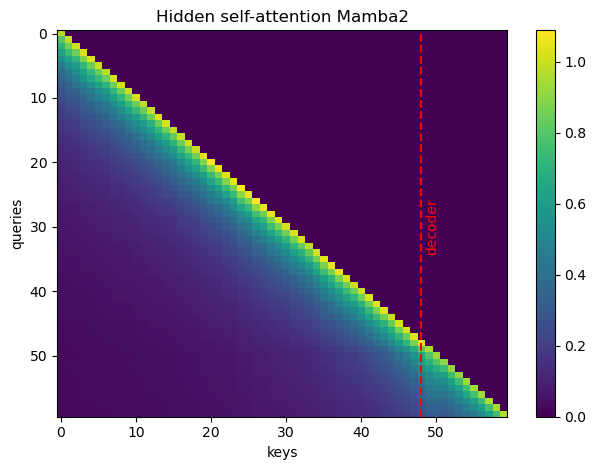

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


for i in range(1):

    horizon = 12  # longueur de la fenêtre de prédiction
    right_rid = 1
    left_rid = 300

    A = hidden_attn.to(torch.float32)[5].mean(dim=0)
    mean_hiddent_attention = hidden_attn.to(torch.float32).mean(0).mean(0)    # (L, L)
    A = mean_hiddent_attention

    self_att = 588 - 60
    dec_dec = A[self_att:, self_att:]     # (12, 12)   decoder self-attn

    # Dossier de sauvegarde
    save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
    os.makedirs(save_dir, exist_ok=True)

    # ---------- Plot 2 ----------
    plt.figure()
    plt.imshow(dec_dec.cpu(), aspect="auto")
    plt.xlabel("keys")
    plt.ylabel("queries")
    plt.title("Hidden self-attention Mamba2")
    plt.colorbar()

    # Ligne verticale 12 points avant la fin
    x_pos = dec_dec.shape[1] - 12
    plt.axvline(x=x_pos, color="red", linestyle="--", linewidth=1.5)

    # Ajouter le texte "decoder"
    plt.text(x_pos + 0.5, dec_dec.shape[0] / 2, "decoder", color="red",
            rotation=90, va="center", ha="left", fontsize=10)

    plt.tight_layout()
    if i == 2:
        plt.savefig(os.path.join(save_dir, "self_attention/decoder_self_attention202.png"), dpi=300)
    plt.show()

    plt.close("all")


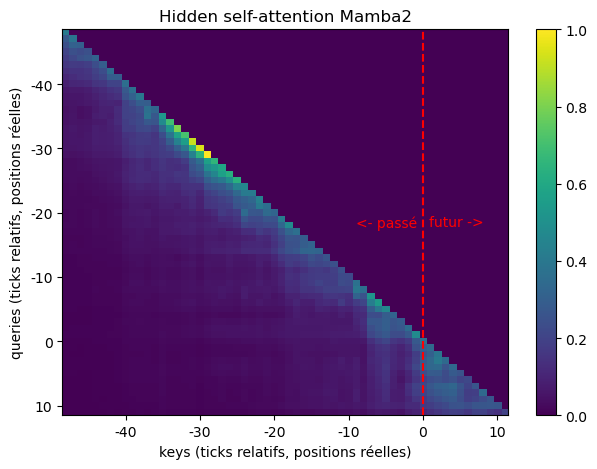

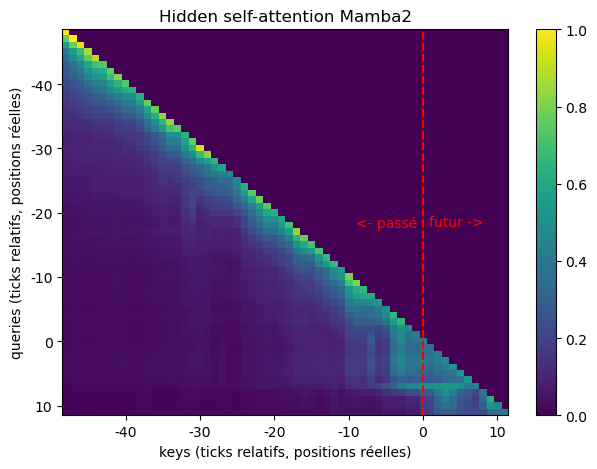

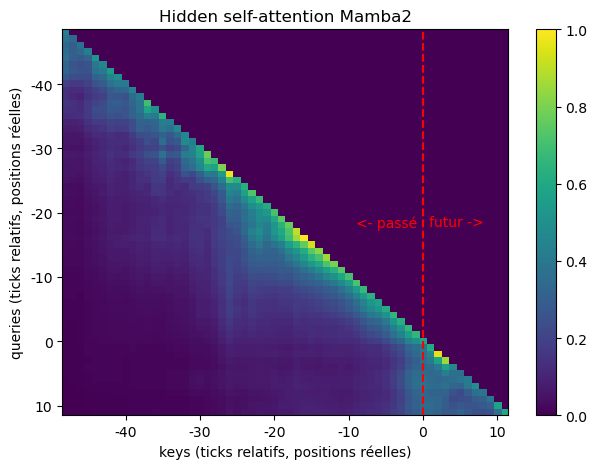

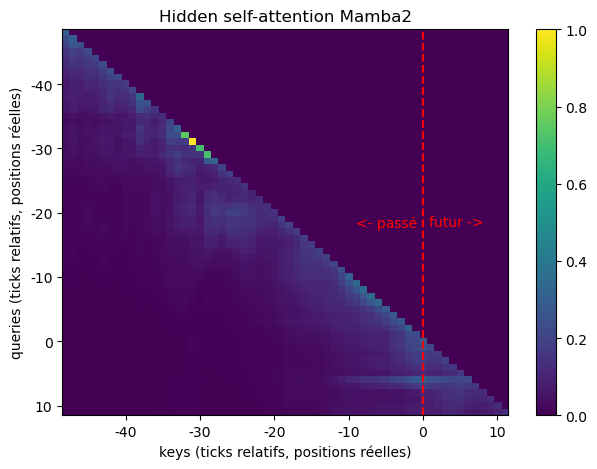

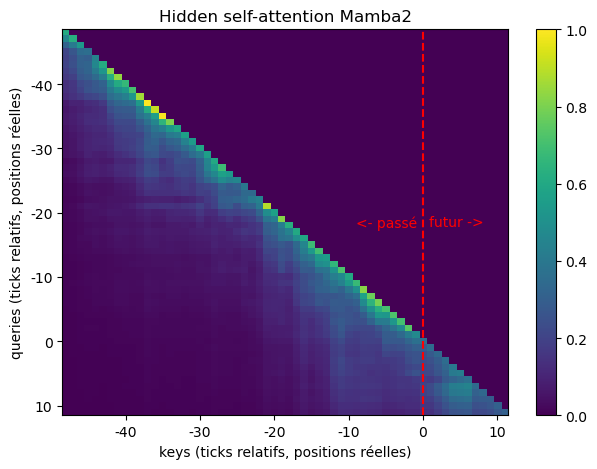

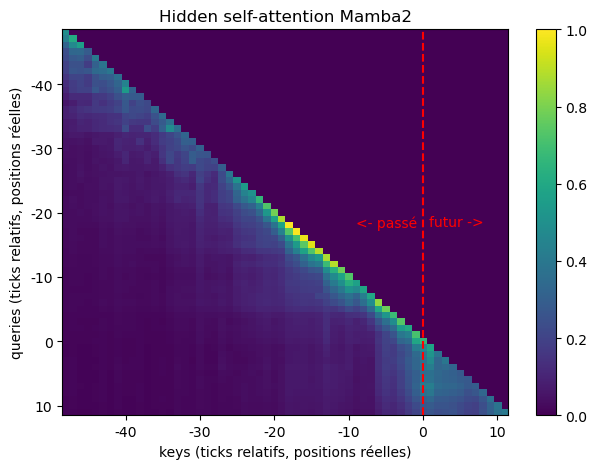

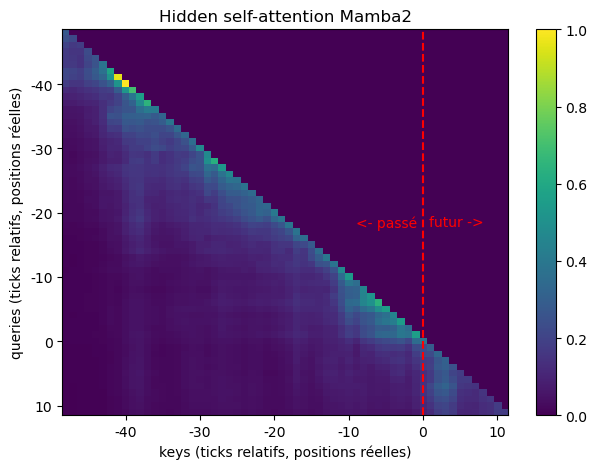

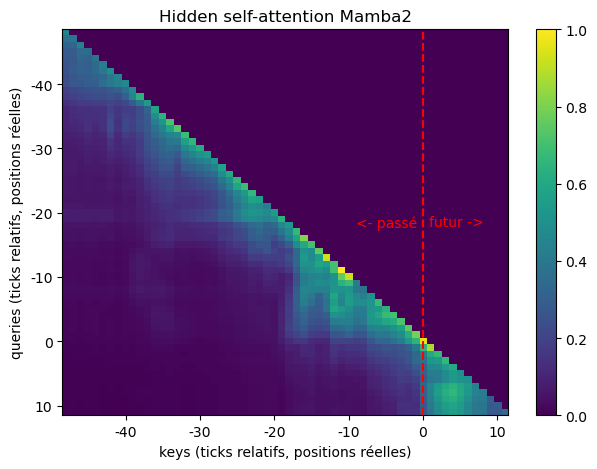

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for j in range(8):
    hidden_attn = attn_heads[j]  # [1, B, L, L]
    horizon = 12                 # nb d'étapes du décodeur

    # --- Agrégation des têtes -> matrice A ---
    # A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
    A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
    if A.dim() == 3:
        A = A[0]  # -> (L, L)

    # --- Bloc decoder self-attention (comme ton code) ---
    self_att = 588 - 60
    dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

    # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
    finite = torch.isfinite(dec_dec)
    if finite.any():
        dmin = dec_dec[finite].min()
        dmax = dec_dec[finite].max()
        if dmax > dmin:
            dec_dec_norm = torch.zeros_like(dec_dec)
            dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)
    else:
        dec_dec_norm = torch.zeros_like(dec_dec)

    # --- Plot ---
    save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
    os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

    fig, ax = plt.subplots()
    im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                   vmin=0.0, vmax=1.0)  # échelle figée 0..1
    ax.set_xlabel("keys (ticks relatifs, positions réelles)")
    ax.set_ylabel("queries (ticks relatifs, positions réelles)")
    ax.set_title("Hidden self-attention Mamba2")
    plt.colorbar(im, ax=ax)

    # Frontière (0 relatif) sur X uniquement (ligne verticale)
    x0 = dec_dec.shape[1] - horizon
    ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)

    # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_x = -x0
    max_rel_x = (dec_dec.shape[1] - 1) - x0
    start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
    end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
    rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
    xticks_abs  = [x0 + r for r in rel_xticks]
    ax.set_xticks(xticks_abs)
    ax.set_xticklabels([str(r) for r in rel_xticks])

    # --- Ticks Y: par 10, labels relatifs (positions réelles conservées), SANS ligne rouge ---
    y0 = dec_dec.shape[0] - horizon  # 0 relatif en Y
    min_rel_y = -y0
    max_rel_y = (dec_dec.shape[0] - 1) - y0
    start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
    end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
    rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
    yticks_abs  = [y0 + r for r in rel_yticks]
    ax.set_yticks(yticks_abs)
    ax.set_yticklabels([str(r) for r in rel_yticks])

    # (optionnel) repères texte seulement pour X
    y_mid = (dec_dec.shape[0] - 1) / 2
    pad_cols = 0.8
    ax.text(x0 - pad_cols, y_mid, "<- passé", va="center", ha="right",
            color="red", fontsize=10, clip_on=False)
    ax.text(x0 + pad_cols, y_mid, "futur ->", va="center", ha="left",
            color="red", fontsize=10, clip_on=False)

    plt.tight_layout()
    if i == 2:
        plt.savefig(os.path.join(save_dir, "self_attention/decoder_self_attention202.png"), dpi=300)
    plt.show()
    plt.close("all")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for i in range(1):
    for j in range(8):
        # hidden_attn = attn_heads[i]  # [1, B, L, L]
        horizon = 12                 # nb d'étapes du décodeur

        # --- Agrégation des têtes -> matrice A ---
        # A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
        A = attn_heads.to(torch.float32)[5][j]
        # A = hidden_attn.to(torch.float32).mean(0).mean(0)

        if A.dim() == 3:
            A = A[0]  # -> (L, L)

        # --- Bloc decoder self-attention (comme ton code) ---
        self_att = 588 - 60
        dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

        # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
        finite = torch.isfinite(dec_dec)
        if finite.any():
            dmin = dec_dec[finite].min()
            dmax = dec_dec[finite].max()
            if dmax > dmin:
                dec_dec_norm = torch.zeros_like(dec_dec)
                dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
            else:
                dec_dec_norm = torch.zeros_like(dec_dec)  # matrice constante
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)

        # --- Plot ---
        save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
        os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

        fig, ax = plt.subplots()
        im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                    vmin=0.0, vmax=1.0)  # échelle figée 0..1
        ax.set_xlabel("keys")
        ax.set_ylabel("queries")
        ax.set_title("Hidden self-attention Mamba2")
        plt.colorbar(im, ax=ax)

        # Frontières 0 (début du décodeur) sur X et Y
        x0 = dec_dec.shape[1] - horizon
        y0 = dec_dec.shape[0] - horizon
        ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)
        ax.axhline(y=y0, color="red", linestyle="--", linewidth=1.5)

        # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
        min_rel_x = -x0
        max_rel_x = (dec_dec.shape[1] - 1) - x0
        start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
        end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
        rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
        xticks_abs  = [x0 + r for r in rel_xticks]
        ax.set_xticks(xticks_abs)
        ax.set_xticklabels([str(r) for r in rel_xticks])

        # --- Ticks Y: par 10, labels relatifs (positions réelles conservées) ---
        min_rel_y = -y0
        max_rel_y = (dec_dec.shape[0] - 1) - y0
        start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
        end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
        rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
        yticks_abs  = [y0 + r for r in rel_yticks]
        ax.set_yticks(yticks_abs)
        ax.set_yticklabels([str(r) for r in rel_yticks])

        # (optionnel) repères texte
        x_pad, y_pad = 0.8, 0.8
        y_mid = (dec_dec.shape[0] - 1) / 2
        x_mid = (dec_dec.shape[1] - 1) / 2
        ax.text(x0 - x_pad, y_mid, "<- encoder", va="center", ha="right",
                color="red", fontsize=10, clip_on=False)
        ax.text(x0 + x_pad, y_mid, "decoder ->", va="center", ha="left",
                color="red", fontsize=10, clip_on=False)
        plt.tight_layout()
        plt.show()
        plt.close("all")


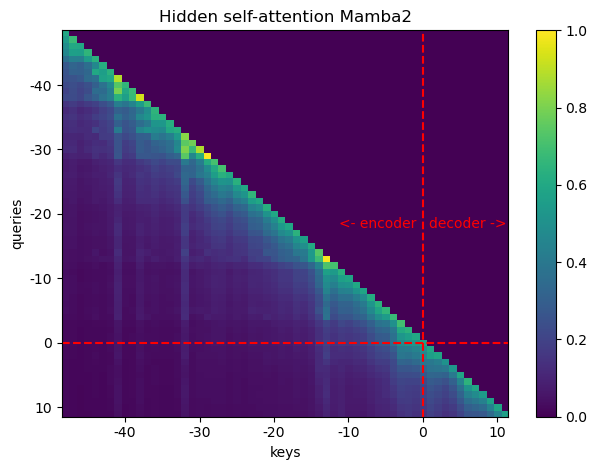

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for i in range(1):
    # hidden_attn = attn_heads[i]  # [1, B, L, L]
    horizon = 12                 # nb d'étapes du décodeur

    # --- Agrégation des têtes -> matrice A ---
    # A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
    A = attn_heads.to(torch.float32)[5].mean(dim=0)
    # A = hidden_attn.to(torch.float32).mean(0).mean(0)

    if A.dim() == 3:
        A = A[0]  # -> (L, L)

    # --- Bloc decoder self-attention (comme ton code) ---
    self_att = 588 - 60
    dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

    # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
    finite = torch.isfinite(dec_dec)
    if finite.any():
        dmin = dec_dec[finite].min()
        dmax = dec_dec[finite].max()
        if dmax > dmin:
            dec_dec_norm = torch.zeros_like(dec_dec)
            dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)  # matrice constante
    else:
        dec_dec_norm = torch.zeros_like(dec_dec)

    # --- Plot ---
    save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
    os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

    fig, ax = plt.subplots()
    im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                   vmin=0.0, vmax=1.0)  # échelle figée 0..1
    ax.set_xlabel("keys")
    ax.set_ylabel("queries")
    ax.set_title("Hidden self-attention Mamba2")
    plt.colorbar(im, ax=ax)

    # Frontières 0 (début du décodeur) sur X et Y
    x0 = dec_dec.shape[1] - horizon
    y0 = dec_dec.shape[0] - horizon
    ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)
    ax.axhline(y=y0, color="red", linestyle="--", linewidth=1.5)

    # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_x = -x0
    max_rel_x = (dec_dec.shape[1] - 1) - x0
    start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
    end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
    rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
    xticks_abs  = [x0 + r for r in rel_xticks]
    ax.set_xticks(xticks_abs)
    ax.set_xticklabels([str(r) for r in rel_xticks])

    # --- Ticks Y: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_y = -y0
    max_rel_y = (dec_dec.shape[0] - 1) - y0
    start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
    end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
    rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
    yticks_abs  = [y0 + r for r in rel_yticks]
    ax.set_yticks(yticks_abs)
    ax.set_yticklabels([str(r) for r in rel_yticks])

    # (optionnel) repères texte
    x_pad, y_pad = 0.8, 0.8
    y_mid = (dec_dec.shape[0] - 1) / 2
    x_mid = (dec_dec.shape[1] - 1) / 2
    ax.text(x0 - x_pad, y_mid, "<- encoder", va="center", ha="right",
            color="red", fontsize=10, clip_on=False)
    ax.text(x0 + x_pad, y_mid, "decoder ->", va="center", ha="left",
            color="red", fontsize=10, clip_on=False)

    plt.tight_layout()
    plt.show()
    plt.close("all")


In [ ]:
A.shape

torch.Size([588, 588])

## Temporat processing (replacement of LSTM)

In [28]:
lstm = tft.lstm_encoder

lstm._record = True

# b) on dit à chaque bloc Mamba de vraiment calculer la carte
for blk in lstm.blocks:            # depth=1 → une seule boucle
    blk.mamba._record = True
    blk.mamba.use_mem_eff_path = False  # pour rendre les intermédiaires accessibles


In [29]:
device = torch.device("cuda", 0)           # ou "cuda" si une seule carte
tft = tft.to(device)                       # modèle

batch = batch = list(val_dataloader)[20] 
x, y = batch
x_dict = {k: v.to(device) for k, v in x.items()}

torch.set_grad_enabled(True)               # garder les gradients
tft.eval()


with torch.no_grad():
    net_out = tft(x_dict)

In [30]:
i = 0  # ton index interne éventuel
save = []
A_log_list = []

# beaucoup d'implémentations ont un attribut ModuleList appelé "blocks"
for blk in tft.lstm_encoder.blocks:     # <- au lieu de: for blk in tft.lstm_encoder

    blk = blk.mamba
    dt_save, A_log_exp, B_in_h, C_in = blk.get_saved_internals()  # si le bloc expose .mamba, sinon c'est lui-même
    pack = dt_save, B_in_h, C_in
    save.append(pack)
    A_log_list.append(A_log_exp)

    i = i + 1

print(i)


4


In [31]:
import numpy as np

attn_list = []

for i in range(4):
    dt_raw, B_in, C_in = save[i]
    A_log_exp =A_log_list[i]
    attn_heads, attn_heads_g = hidden_attention_per_head_mes_chunked(
        dt_raw=dt_raw,
        A_log=A_log_exp,
        B_in=B_in,
        C_in=C_in,
        sample_idx=None,             # ne visualiser qu’un exemple (évite OOM)
        causal=True,
        normalize="softmax",
        return_per_group=True,    # si tu veux la décomposition par groupe
        ngroups=blk.ngroups,
        reduce_states="sum",
    )

    attn_list.append(attn_heads)

attn_list = np.stack(attn_list, axis=0)


In [32]:
attn_list.shape

(4, 32, 8, 588, 588)

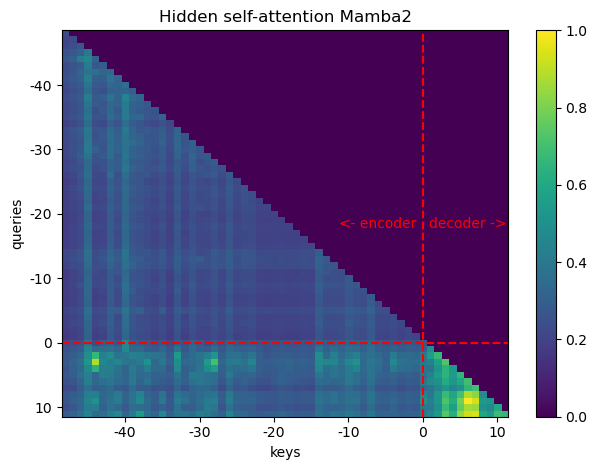

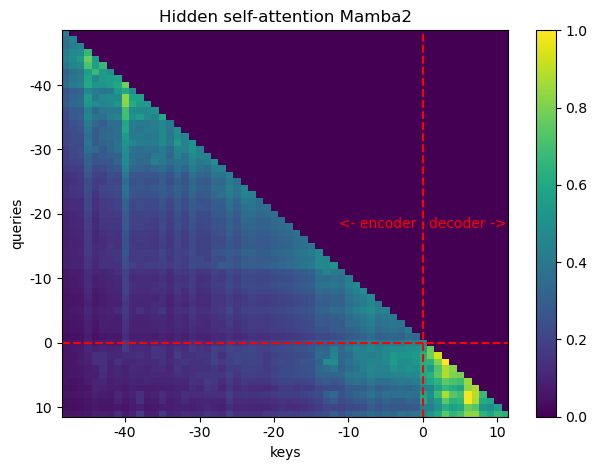

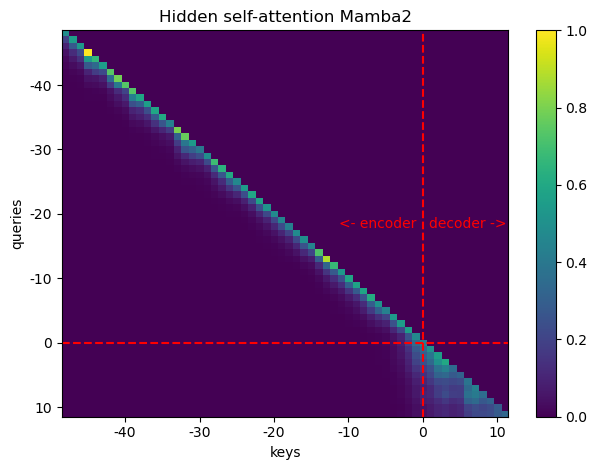

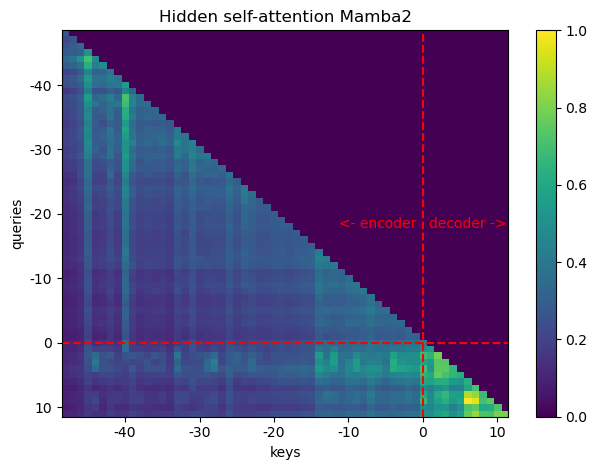

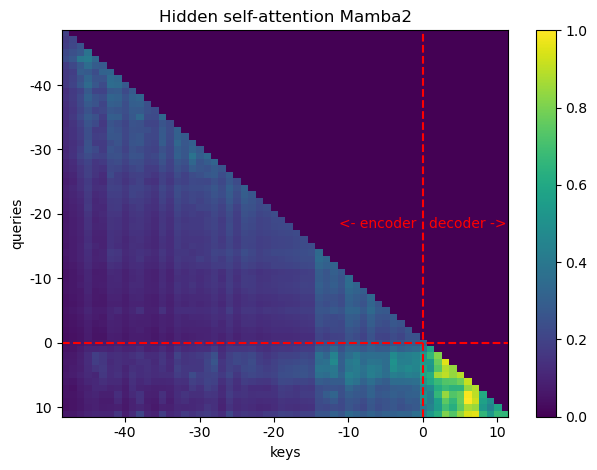

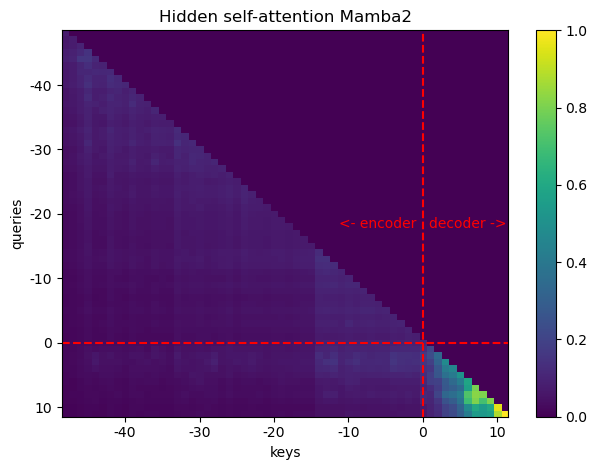

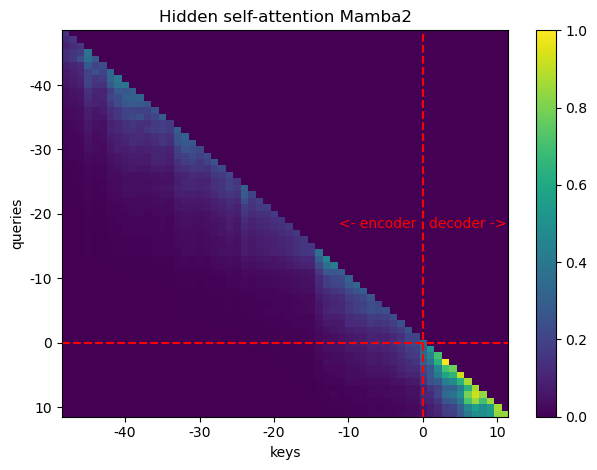

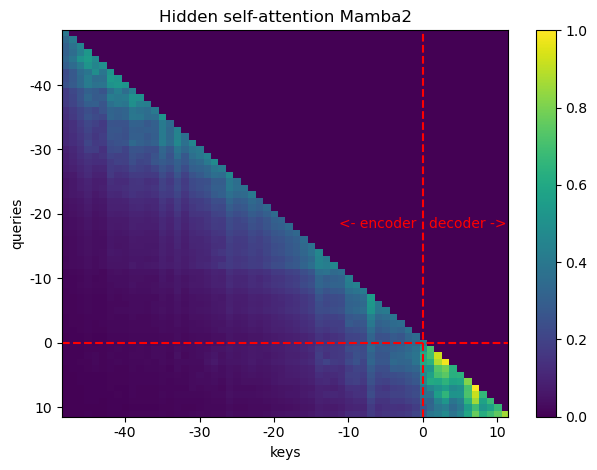

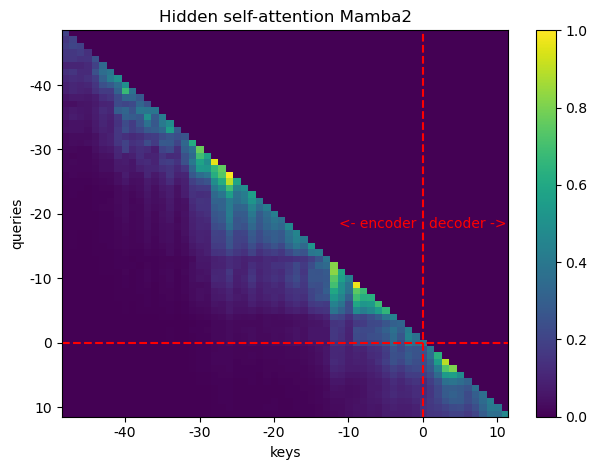

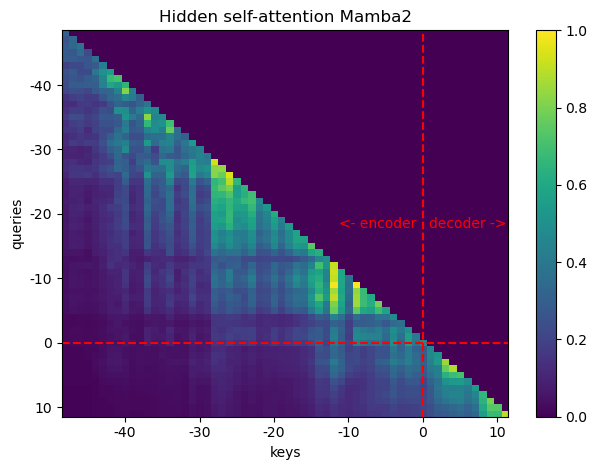

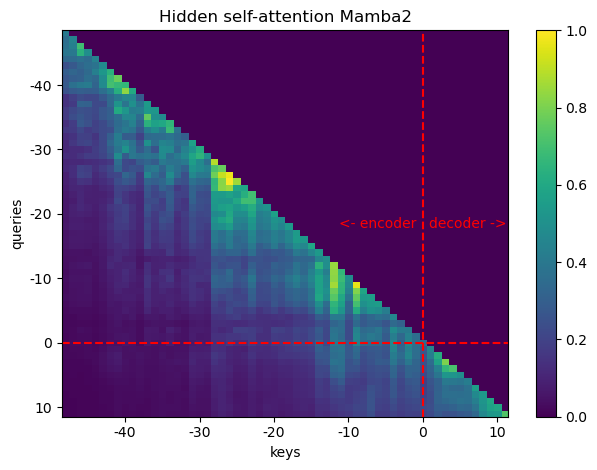

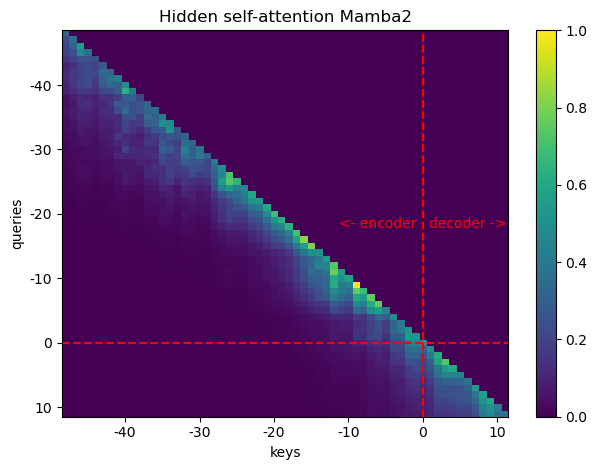

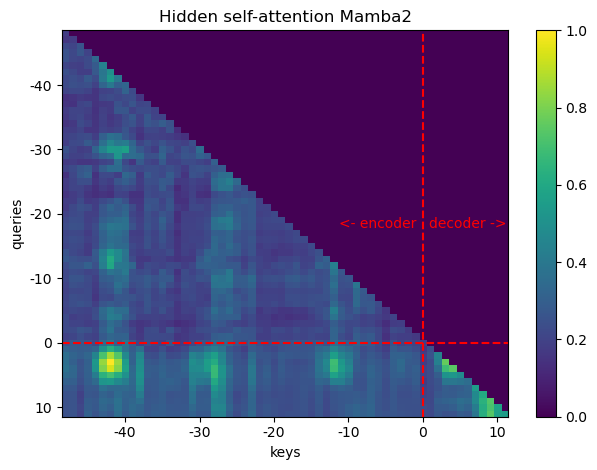

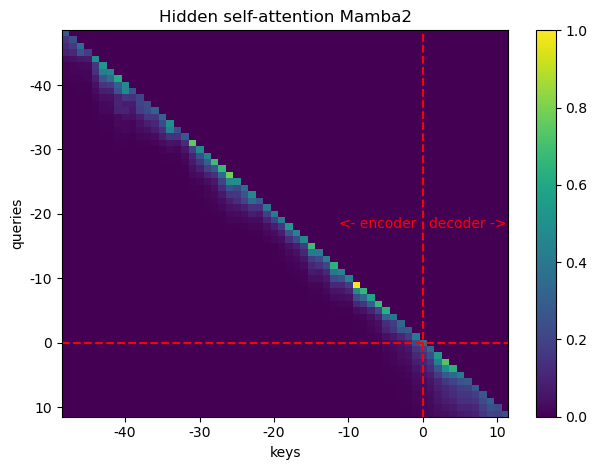

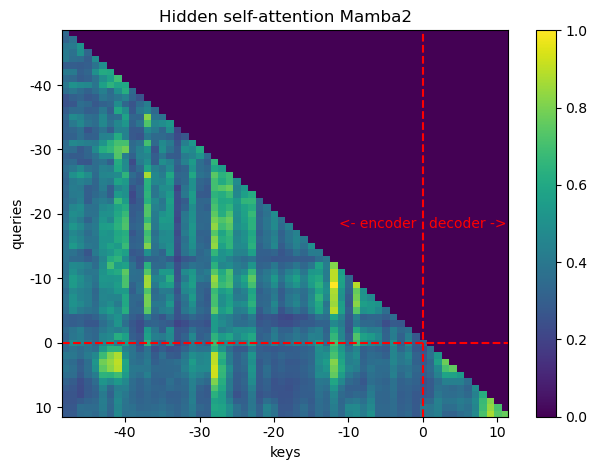

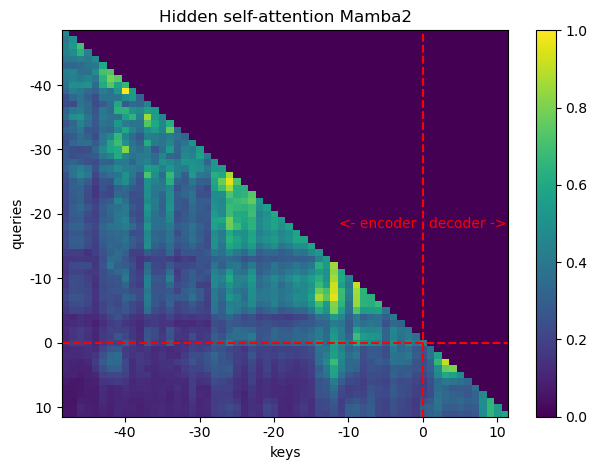

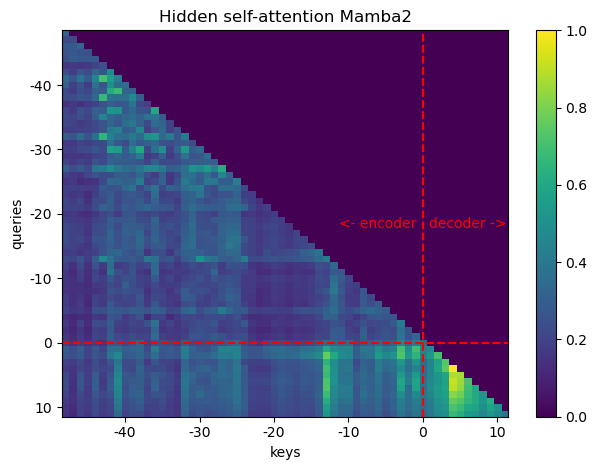

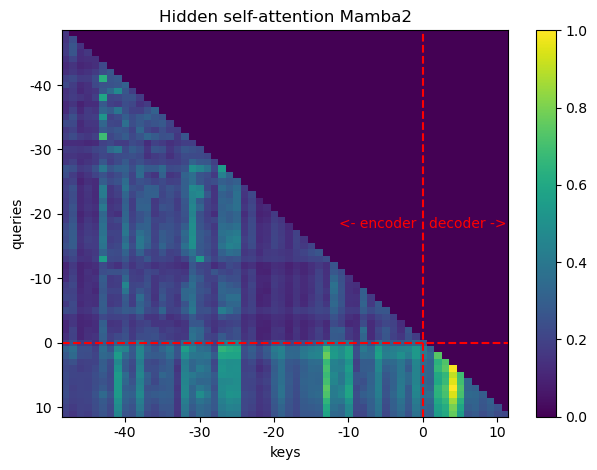

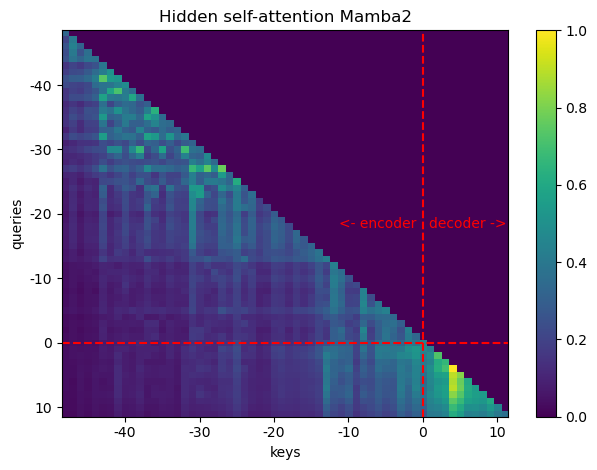

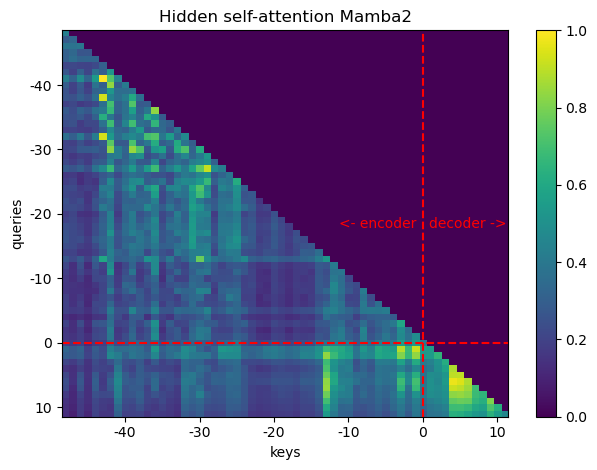

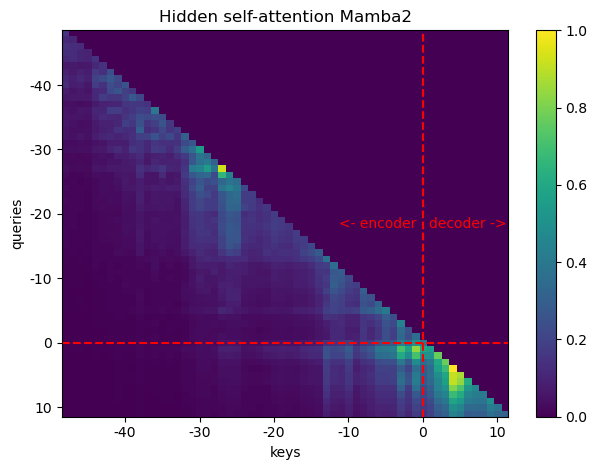

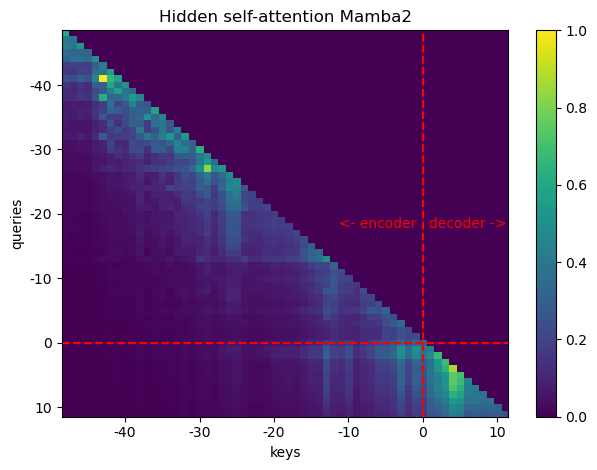

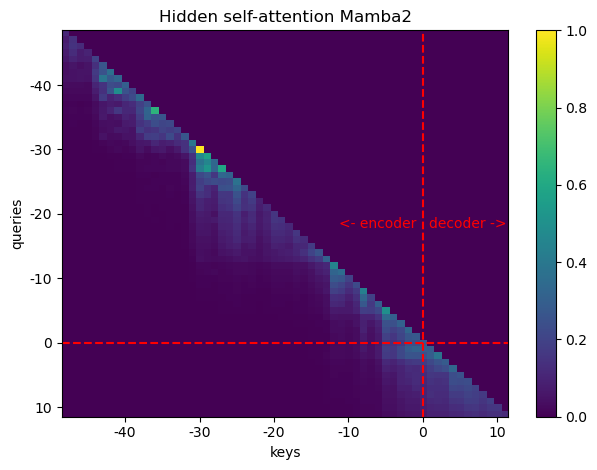

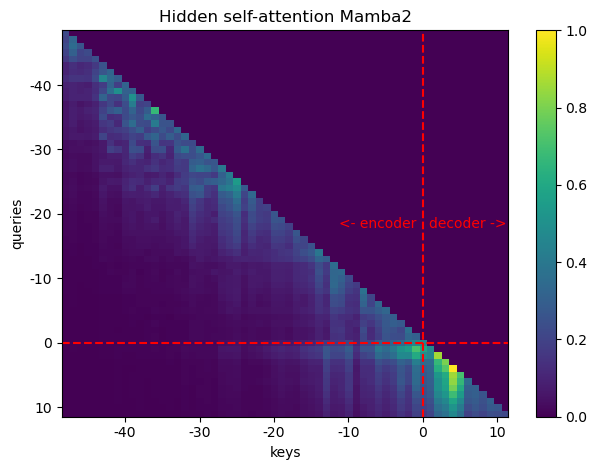

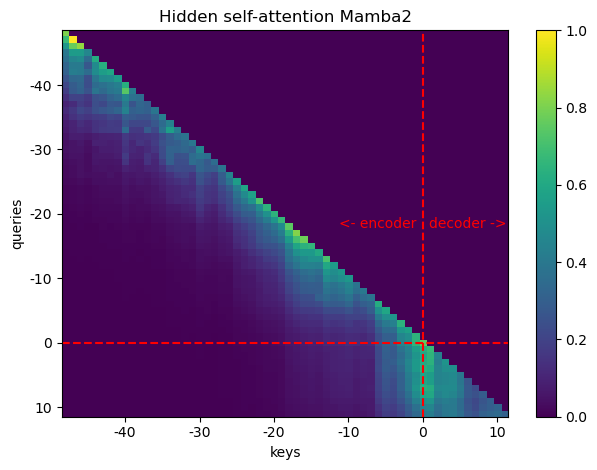

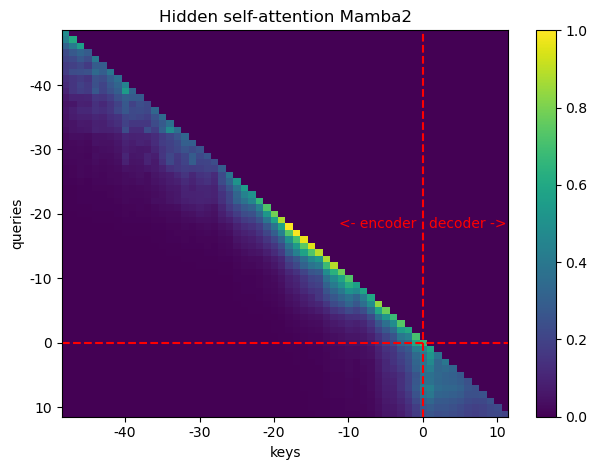

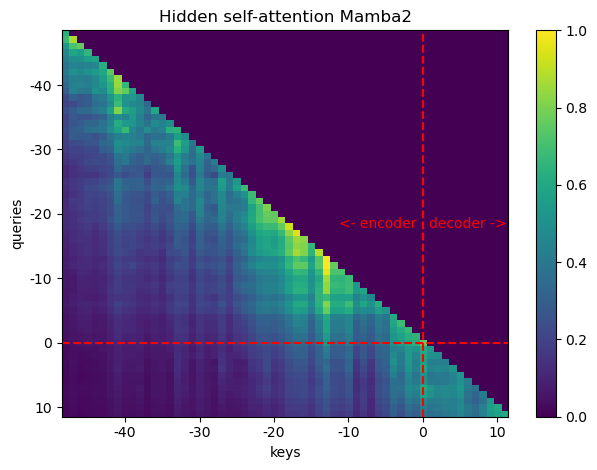

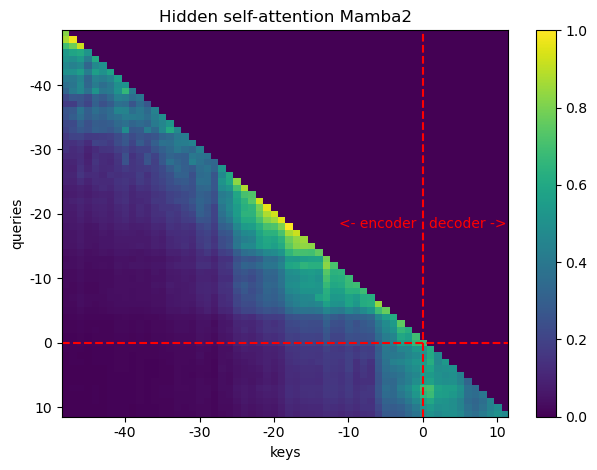

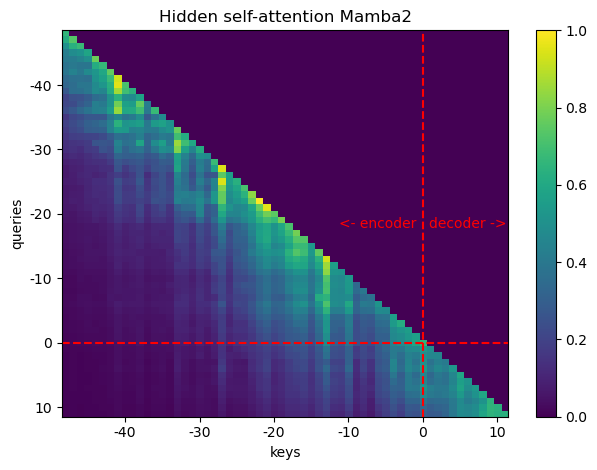

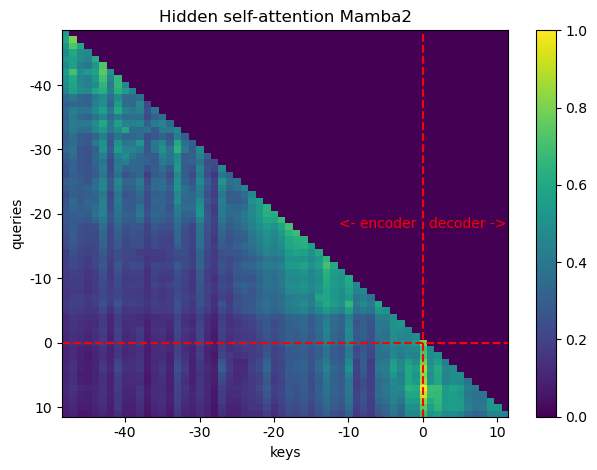

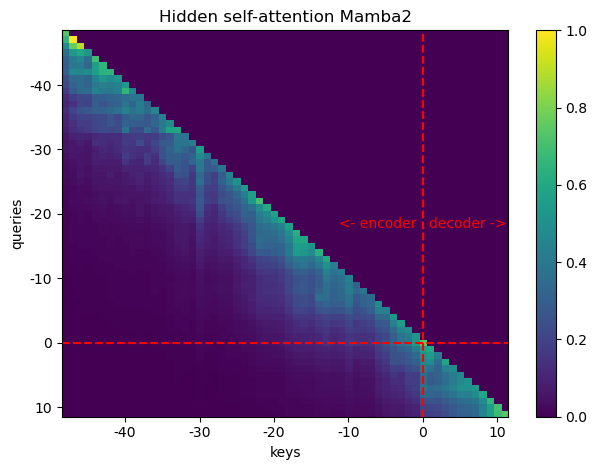

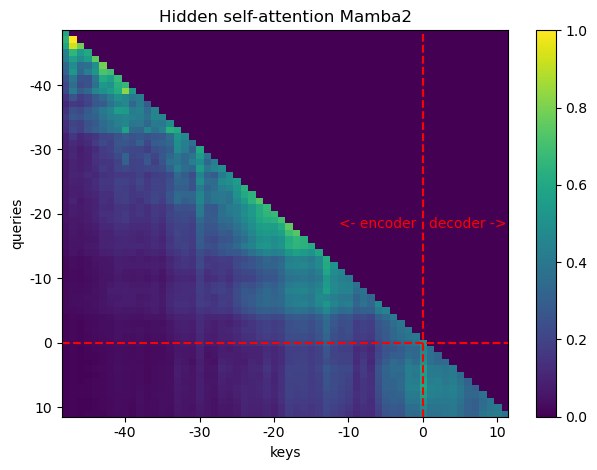

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for i in range(4):
    for j in range(8):
        horizon = 12                 # nb d'étapes du décodeur

        # --- Agrégation des têtes -> matrice A ---
        A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
        A = attn_list[i][5][j]
        A = torch.tensor(A, dtype=torch.float32)
        if A.dim() == 3:
            A = A[0]  # -> (L, L)

        # --- Bloc decoder self-attention (comme ton code) ---
        self_att = 588 - 60
        dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

        # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
        finite = torch.isfinite(dec_dec)
        if finite.any():
            dmin = dec_dec[finite].min()
            dmax = dec_dec[finite].max()
            if dmax > dmin:
                dec_dec_norm = torch.zeros_like(dec_dec)
                dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
            else:
                dec_dec_norm = torch.zeros_like(dec_dec)  # matrice constante
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)

        # --- Plot ---
        save_dir = "/home/yentlcollin/CGM/mambatf/load_model/new global inter/Mean_stacked"
        os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

        fig, ax = plt.subplots()
        im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                    vmin=0.0, vmax=1.0)  # échelle figée 0..1
        ax.set_xlabel("keys")
        ax.set_ylabel("queries")
        ax.set_title("Hidden self-attention Mamba2")
        plt.colorbar(im, ax=ax)

        # Frontières 0 (début du décodeur) sur X et Y
        x0 = dec_dec.shape[1] - horizon
        y0 = dec_dec.shape[0] - horizon
        ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)
        ax.axhline(y=y0, color="red", linestyle="--", linewidth=1.5)

        # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
        min_rel_x = -x0
        max_rel_x = (dec_dec.shape[1] - 1) - x0
        start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
        end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
        rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
        xticks_abs  = [x0 + r for r in rel_xticks]
        ax.set_xticks(xticks_abs)
        ax.set_xticklabels([str(r) for r in rel_xticks])

        # --- Ticks Y: par 10, labels relatifs (positions réelles conservées) ---
        min_rel_y = -y0
        max_rel_y = (dec_dec.shape[0] - 1) - y0
        start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
        end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
        rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
        yticks_abs  = [y0 + r for r in rel_yticks]
        ax.set_yticks(yticks_abs)
        ax.set_yticklabels([str(r) for r in rel_yticks])

        # (optionnel) repères texte
        x_pad, y_pad = 0.8, 0.8
        y_mid = (dec_dec.shape[0] - 1) / 2
        x_mid = (dec_dec.shape[1] - 1) / 2
        ax.text(x0 - x_pad, y_mid, "<- encoder", va="center", ha="right",
                color="red", fontsize=10, clip_on=False)
        ax.text(x0 + x_pad, y_mid, "decoder ->", va="center", ha="left",
                color="red", fontsize=10, clip_on=False)
        # ax.text(x_mid, y0 - y_pad, "passé ↑", va="top", ha="center",
        #         color="red", fontsize=10, clip_on=False)
        # ax.text(x_mid, y0 + y_pad, "↓ futur", va="bottom", ha="center",
        #         color="red", fontsize=10, clip_on=False)

        # plt.savefig(os.path.join(save_dir, f"mean_SA_l_{i}_h_{j}.png"), dpi=300)

        plt.tight_layout()
        # if i == 2:
        #     plt.savefig(os.path.join(save_dir, "self_attention/decoder_self_attention202.png"), dpi=300)
        # plt.savefig(os.path.join(save_dir, f"self_attention/decoder_self_attention.png"), dpi=300)
        plt.show()
        plt.close("all")


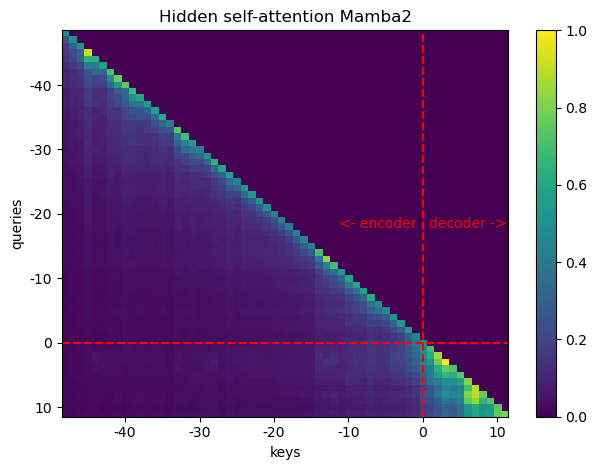

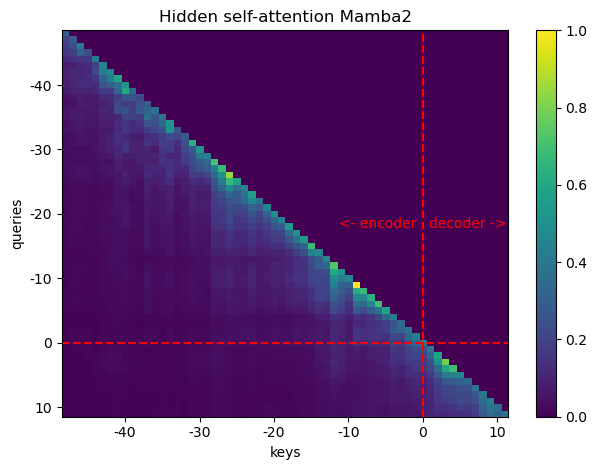

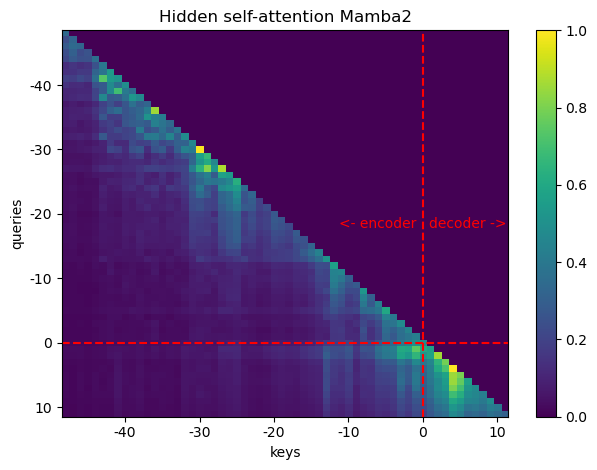

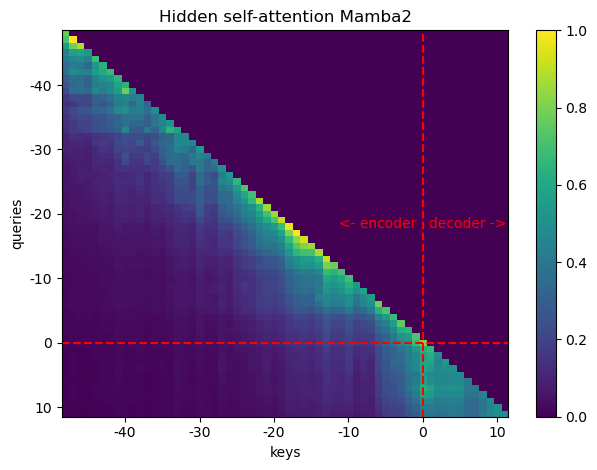

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for i in range(4):
    horizon = 12                 # nb d'étapes du décodeur

    # --- Agrégation des têtes -> matrice A ---
    A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
    A = attn_list[i][0].mean(0)
    A = A.to(torch.float32)
    if A.dim() == 3:
        A = A[0]  # -> (L, L)

    # --- Bloc decoder self-attention (comme ton code) ---
    self_att = 588 - 60
    dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

    # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
    finite = torch.isfinite(dec_dec)
    if finite.any():
        dmin = dec_dec[finite].min()
        dmax = dec_dec[finite].max()
        if dmax > dmin:
            dec_dec_norm = torch.zeros_like(dec_dec)
            dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)  # matrice constante
    else:
        dec_dec_norm = torch.zeros_like(dec_dec)

    # --- Plot ---
    save_dir = "/home/yentlcollin/CGM/mambatf/load_model/folder_save"
    os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

    fig, ax = plt.subplots()
    im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                   vmin=0.0, vmax=1.0)  # échelle figée 0..1
    ax.set_xlabel("keys")
    ax.set_ylabel("queries")
    ax.set_title("Hidden self-attention Mamba2")
    plt.colorbar(im, ax=ax)

    # Frontières 0 (début du décodeur) sur X et Y
    x0 = dec_dec.shape[1] - horizon
    y0 = dec_dec.shape[0] - horizon
    ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)
    ax.axhline(y=y0, color="red", linestyle="--", linewidth=1.5)

    # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_x = -x0
    max_rel_x = (dec_dec.shape[1] - 1) - x0
    start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
    end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
    rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
    xticks_abs  = [x0 + r for r in rel_xticks]
    ax.set_xticks(xticks_abs)
    ax.set_xticklabels([str(r) for r in rel_xticks])

    # --- Ticks Y: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_y = -y0
    max_rel_y = (dec_dec.shape[0] - 1) - y0
    start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
    end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
    rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
    yticks_abs  = [y0 + r for r in rel_yticks]
    ax.set_yticks(yticks_abs)
    ax.set_yticklabels([str(r) for r in rel_yticks])

    # (optionnel) repères texte
    x_pad, y_pad = 0.8, 0.8
    y_mid = (dec_dec.shape[0] - 1) / 2
    x_mid = (dec_dec.shape[1] - 1) / 2
    ax.text(x0 - x_pad, y_mid, "<- encoder", va="center", ha="right",
            color="red", fontsize=10, clip_on=False)
    ax.text(x0 + x_pad, y_mid, "decoder ->", va="center", ha="left",
            color="red", fontsize=10, clip_on=False)


    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"self_attention/decoder_self_attention.png"), dpi=300)
    plt.show()
    plt.close("all")


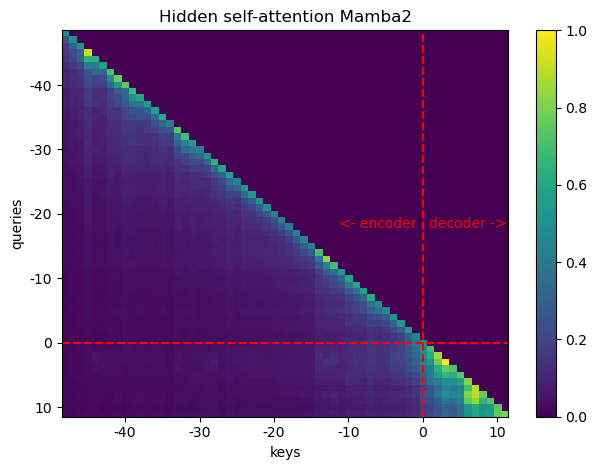

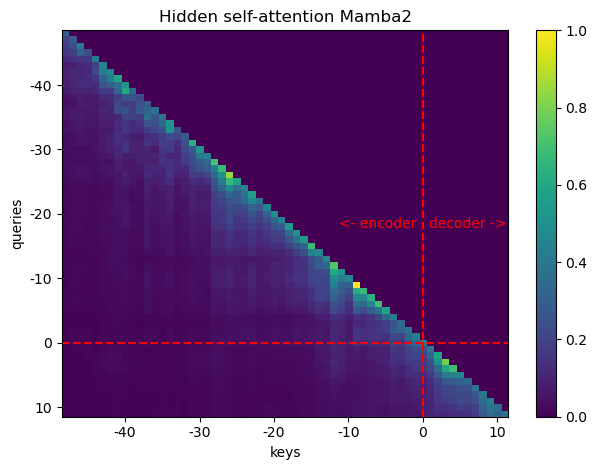

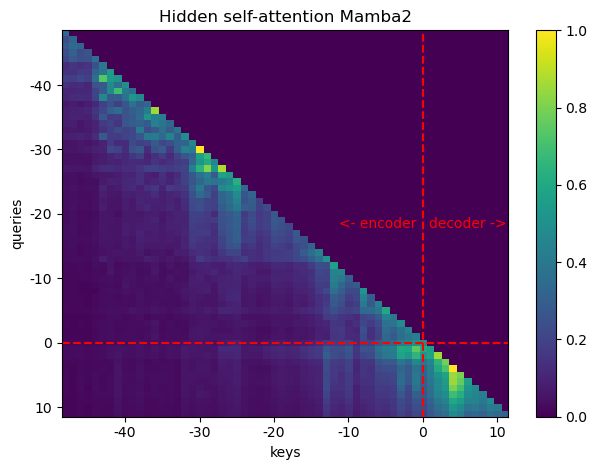

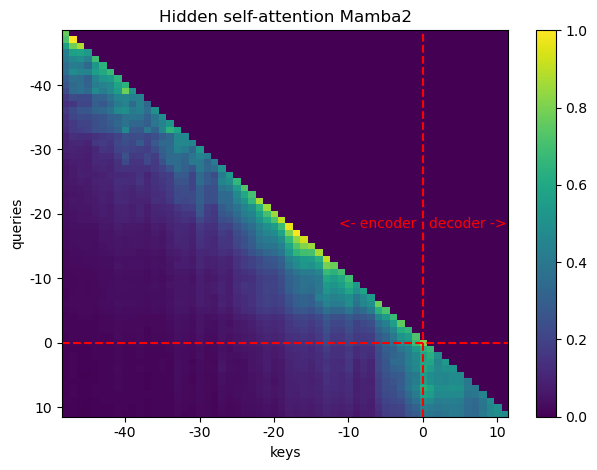

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

for i in range(4):
    horizon = 12                 # nb d'étapes du décodeur

    # --- Agrégation des têtes -> matrice A ---
    A = hidden_attn.to(torch.float32).max(0).values  # (B, L, L) si B>1
    A = attn_list[i][5].mean(0)
    # A = A.to(torch.float32)
    A = torch.tensor(A, dtype=torch.float32)

    if A.dim() == 3:
        A = A[0]  # -> (L, L)

    # --- Bloc decoder self-attention (comme ton code) ---
    self_att = 588 - 60
    dec_dec = A[self_att:, self_att:]  # (L_dec, L_dec)

    # -------- Normalisation min-max -> [0, 1] (NaN/Inf safe) --------
    finite = torch.isfinite(dec_dec)
    if finite.any():
        dmin = dec_dec[finite].min()
        dmax = dec_dec[finite].max()
        if dmax > dmin:
            dec_dec_norm = torch.zeros_like(dec_dec)
            dec_dec_norm[finite] = (dec_dec[finite] - dmin) / (dmax - dmin)
        else:
            dec_dec_norm = torch.zeros_like(dec_dec)  # matrice constante
    else:
        dec_dec_norm = torch.zeros_like(dec_dec)

    # --- Plot ---
    save_dir =  "/home/yentlcollin/CGM/mambatf/load_model/new global inter/meanmeanstacked"
    os.makedirs(os.path.join(save_dir, "self_attention"), exist_ok=True)

    fig, ax = plt.subplots()
    im = ax.imshow(dec_dec_norm.detach().cpu().numpy(), aspect="auto",
                   vmin=0.0, vmax=1.0)  # échelle figée 0..1
    ax.set_xlabel("keys")
    ax.set_ylabel("queries")
    ax.set_title("Hidden self-attention Mamba2")
    plt.colorbar(im, ax=ax)

    # Frontières 0 (début du décodeur) sur X et Y
    x0 = dec_dec.shape[1] - horizon
    y0 = dec_dec.shape[0] - horizon
    ax.axvline(x=x0, color="red", linestyle="--", linewidth=1.5)
    ax.axhline(y=y0, color="red", linestyle="--", linewidth=1.5)

    # --- Ticks X: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_x = -x0
    max_rel_x = (dec_dec.shape[1] - 1) - x0
    start_rel_x = int(np.ceil(min_rel_x / 10.0)) * 10
    end_rel_x   = int(np.floor(max_rel_x / 10.0)) * 10
    rel_xticks  = list(range(start_rel_x, end_rel_x + 1, 10))
    xticks_abs  = [x0 + r for r in rel_xticks]
    ax.set_xticks(xticks_abs)
    ax.set_xticklabels([str(r) for r in rel_xticks])

    # --- Ticks Y: par 10, labels relatifs (positions réelles conservées) ---
    min_rel_y = -y0
    max_rel_y = (dec_dec.shape[0] - 1) - y0
    start_rel_y = int(np.ceil(min_rel_y / 10.0)) * 10
    end_rel_y   = int(np.floor(max_rel_y / 10.0)) * 10
    rel_yticks  = list(range(start_rel_y, end_rel_y + 1, 10))
    yticks_abs  = [y0 + r for r in rel_yticks]
    ax.set_yticks(yticks_abs)
    ax.set_yticklabels([str(r) for r in rel_yticks])

    # (optionnel) repères texte
    x_pad, y_pad = 0.8, 0.8
    y_mid = (dec_dec.shape[0] - 1) / 2
    x_mid = (dec_dec.shape[1] - 1) / 2
    ax.text(x0 - x_pad, y_mid, "<- encoder", va="center", ha="right",
            color="red", fontsize=10, clip_on=False)
    ax.text(x0 + x_pad, y_mid, "decoder ->", va="center", ha="left",
            color="red", fontsize=10, clip_on=False)
    # ax.text(x_mid, y0 - y_pad, "passé ↑", va="top", ha="center",
    #         color="red", fontsize=10, clip_on=False)
    # ax.text(x_mid, y0 + y_pad, "↓ futur", va="bottom", ha="center",
    #         color="red", fontsize=10, clip_on=False)


    # plt.savefig(os.path.join(save_dir, f"mean_SA_l_{i}_mean.png"), dpi=300)

    plt.tight_layout()
    # if i == 2:
    #     plt.savefig(os.path.join(save_dir, "self_attention/decoder_self_attention202.png"), dpi=300)
    # plt.savefig(os.path.join(save_dir, f"self_attention/decoder_self_attention.png"), dpi=300)
    plt.show()
    plt.close("all")


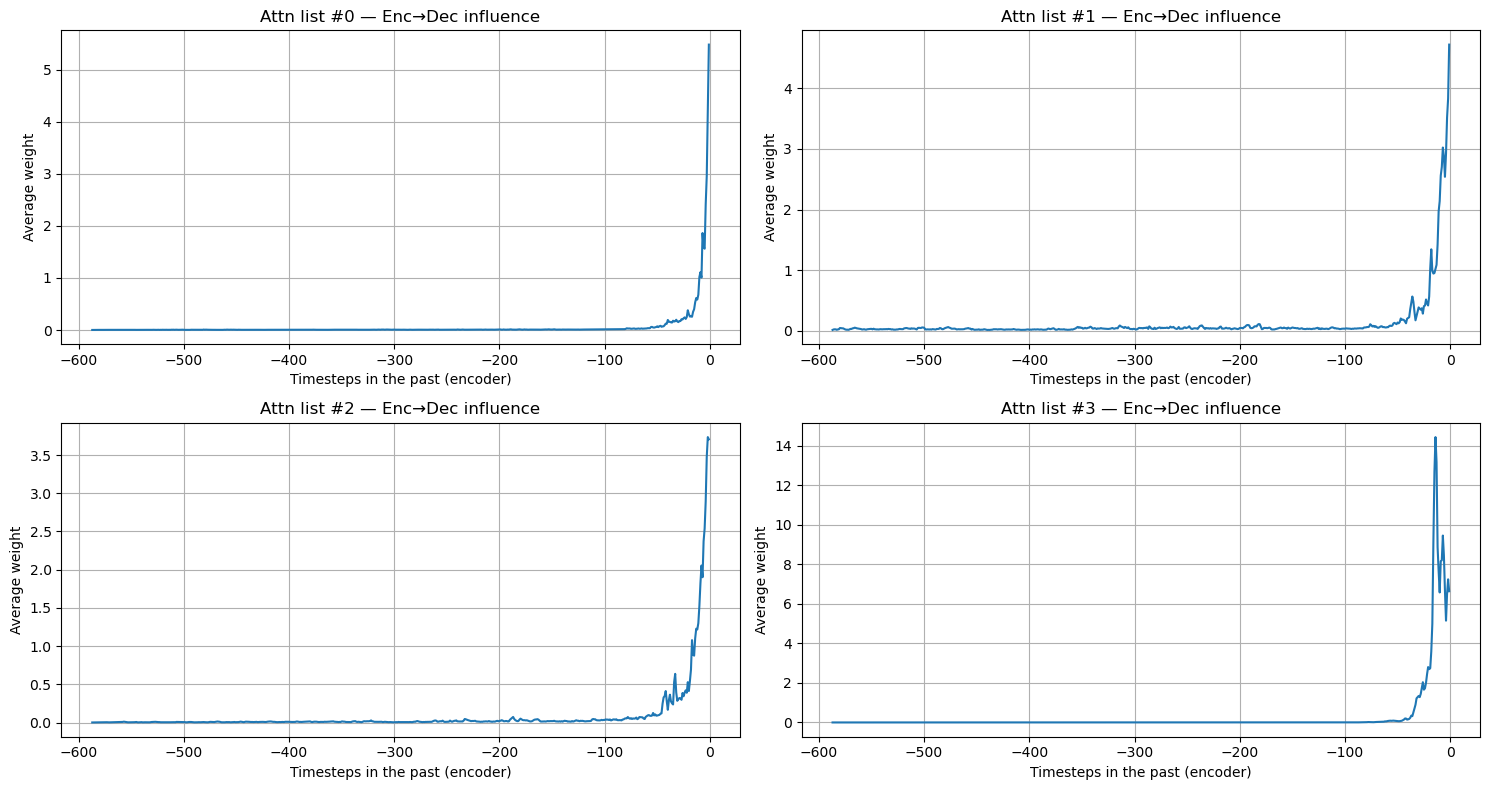

In [103]:
import torch
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

horizon = 1  # longueur de la fenêtre de prédiction

for i in range(4):
    hidden_attn = attn_list[i][0].mean(0)  # shape: [1, B, 300, 300]
    A = hidden_attn.to(torch.float32)

    encoder_len = A.shape[0] - horizon  # 288
    enc_dec = A[-horizon:, 0:encoder_len]  # (12, 288)
    avg_enc_influence = enc_dec.max(0).values  # (288,)

    ax = axes[i]
    ax.plot(np.arange(-encoder_len, 0), avg_enc_influence.cpu())
    ax.set_xlabel("Timesteps in the past (encoder)")
    ax.set_ylabel("Average weight")
    ax.set_title(f"Attn list #{i} — Enc→Dec influence")
    ax.grid(True)


plt.tight_layout()
plt.show()


# Features importance

## Average

In [13]:
def compute_variable_importance(tft, val_dataloader, device="cuda"):
    tft.to(device)
    tft.eval()

    encoder_importance = []
    decoder_importance = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Computing variable importance"):
            if isinstance(batch, (list, tuple)):
                x = batch[0]   # inputs
            else:
                x = batch

            x = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in x.items()}
            out = tft(x)

            enc_imp = out.encoder_variables.detach().cpu().numpy()
            dec_imp = out.decoder_variables.detach().cpu().numpy()

            encoder_importance.append(enc_imp)
            decoder_importance.append(dec_imp)

    # concat → moyenne → squeeze pour enlever dimensions inutiles
    encoder_importance = np.concatenate(encoder_importance, axis=0).mean(axis=0).squeeze()
    decoder_importance = np.concatenate(decoder_importance, axis=0).mean(axis=0).squeeze()

    # sécurité : transformer en 1D
    encoder_importance = np.array(encoder_importance).ravel()
    decoder_importance = np.array(decoder_importance).ravel()

    enc_dict = dict(zip(tft.encoder_variables, encoder_importance.tolist()))
    dec_dict = dict(zip(tft.decoder_variables, decoder_importance.tolist()))

    return enc_dict, dec_dict


In [14]:
enc_importance, dec_importance = compute_variable_importance(tft, val_dataloader)

print("\n--- Encoder Variable Importance ---")
for k, v in sorted(enc_importance.items(), key=lambda x: -x[1]):
    print(f"{k:25s}: {v:.4f}")

print("\n--- Decoder Variable Importance ---")
for k, v in sorted(dec_importance.items(), key=lambda x: -x[1]):
    print(f"{k:25s}: {v:.4f}")


Computing variable importance: 100%|██████████| 24/24 [00:04<00:00,  5.25it/s]


--- Encoder Variable Importance ---
cgm_glucose              : 0.2563
cgm_diff_lag_1           : 0.1350
predmeal_flag            : 0.0758
heartrate                : 0.0526
relative_time_idx        : 0.0522
respiration_rate         : 0.0514
cgm_rolling_std          : 0.0373
stress_level             : 0.0317
cgm_lag_6                : 0.0311
cgm_lag_3                : 0.0276
cgm_lagdiff_1_3          : 0.0275
tod_cos                  : 0.0260
cgm_lag_1                : 0.0240
activity_steps           : 0.0226
cgm_diff_lag_3           : 0.0222
cgm_lagdiff_3_6          : 0.0212
oxygen_saturation        : 0.0186
calories_value           : 0.0157
tod_sin                  : 0.0150
ds                       : 0.0137
cgm_diff_lag_6           : 0.0127
sleep_stage              : 0.0105
minute_of_day            : 0.0100
cgm_rolling_mean         : 0.0093

--- Decoder Variable Importance ---
respiration_rate         : 0.1333
heartrate                : 0.1301
predmeal_flag            : 0.1077
tod_sin 

In [27]:
import numpy as np
import torch
from tqdm import tqdm

def compute_variable_importance(tft, val_dataloader, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    tft.to(device)
    tft.eval()

    enc_vals, dec_vals, stat_vals = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Computing variable importance"):
            x = batch[0] if isinstance(batch, (list, tuple)) else batch
            x = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in x.items()}

            out = tft(x)

            if hasattr(out, "encoder_variables") and out.encoder_variables is not None:
                enc_vals.append(out.encoder_variables.detach().cpu().numpy())
            if hasattr(out, "decoder_variables") and out.decoder_variables is not None:
                dec_vals.append(out.decoder_variables.detach().cpu().numpy())
            if hasattr(out, "static_variables") and out.static_variables is not None:
                stat_vals.append(out.static_variables.detach().cpu().numpy())

    def reduce_mean_over_leading_axes(vals):
        if not vals:
            return None
        arr = np.concatenate(vals, axis=0)  # -> (B, ..., num_vars)
        # moyenne sur tous les axes sauf le dernier (les variables)
        axes = tuple(range(arr.ndim - 1))
        return arr.mean(axis=axes).ravel()

    enc_imp = reduce_mean_over_leading_axes(enc_vals)
    dec_imp = reduce_mean_over_leading_axes(dec_vals)
    stat_imp = reduce_mean_over_leading_axes(stat_vals)

    # Noms des variables
    enc_names = list(getattr(tft, "encoder_variables", []))
    dec_names = list(getattr(tft, "decoder_variables", []))

    # statiques: essaye tft.static_variables sinon fallback cat+real
    if hasattr(tft, "static_variables") and tft.static_variables:
        stat_names = list(tft.static_variables)
    else:
        stat_names = list(getattr(tft, "static_categorical_variables", [])) + \
                     list(getattr(tft, "static_real_variables", []))

    enc_dict = dict(zip(enc_names, enc_imp.tolist())) if enc_imp is not None else {}
    dec_dict = dict(zip(dec_names, dec_imp.tolist())) if dec_imp is not None else {}
    stat_dict = dict(zip(stat_names, stat_imp.tolist())) if stat_imp is not None else {}

    return enc_dict, dec_dict, stat_dict


In [28]:
enc_importance, dec_importance, stat_importance = compute_variable_importance(tft, val_dataloader)

print("\n--- Encoder Variable Importance ---")
for k, v in sorted(enc_importance.items(), key=lambda x: -x[1]):
    print(f"{k:25s}: {v:.4f}")

print("\n--- Decoder Variable Importance ---")
for k, v in sorted(dec_importance.items(), key=lambda x: -x[1]):
    print(f"{k:25s}: {v:.4f}")

print("\n--- Static Variable Importance ---")
for k, v in sorted(stat_importance.items(), key=lambda x: -x[1]):
    print(f"{k:25s}: {v:.4f}")


Computing variable importance: 100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


--- Encoder Variable Importance ---
cgm_glucose              : 0.2609
cgm_diff_lag_1           : 0.1340
predmeal_flag            : 0.0758
heartrate                : 0.0523
relative_time_idx        : 0.0517
respiration_rate         : 0.0511
cgm_rolling_std          : 0.0369
stress_level             : 0.0309
cgm_lag_6                : 0.0309
cgm_lag_3                : 0.0274
cgm_lagdiff_1_3          : 0.0274
tod_cos                  : 0.0258
cgm_lag_1                : 0.0239
activity_steps           : 0.0225
cgm_diff_lag_3           : 0.0220
cgm_lagdiff_3_6          : 0.0211
oxygen_saturation        : 0.0186
calories_value           : 0.0156
tod_sin                  : 0.0147
ds                       : 0.0138
cgm_diff_lag_6           : 0.0127
minute_of_day            : 0.0107
sleep_stage              : 0.0102
cgm_rolling_mean         : 0.0092

--- Decoder Variable Importance ---
respiration_rate         : 0.1333
heartrate                : 0.1301
predmeal_flag            : 0.1077
tod_sin 

## features importances/static

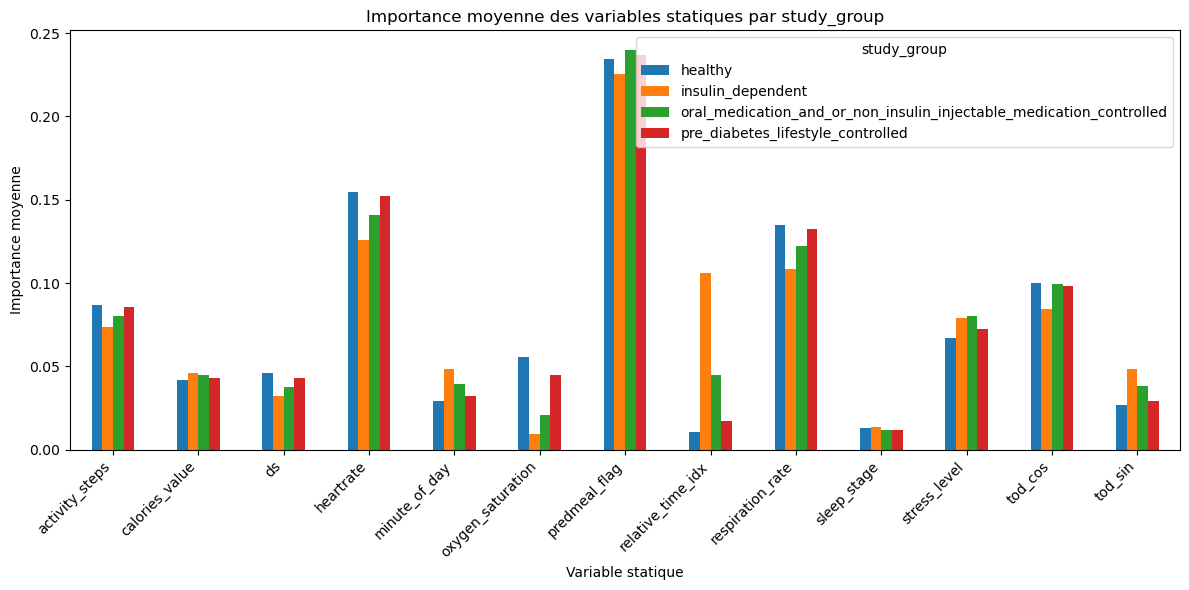

Figure sauvegardée : /home/yentlcollin/CGM/mambatf/Model_mambaTF/out_interpretability/static_importance_by_study_group_decoder.png


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = "/home/yentlcollin/CGM/mambatf/Model_mambaTF/out_interpretability/dec_importances.csv"
path = Path(csv_path)
out_path = path.with_name("static_importance_by_study_group_decoder.png")
plot_mean_importance_by_study_group(csv_path = csv_path, out_path = out_path)


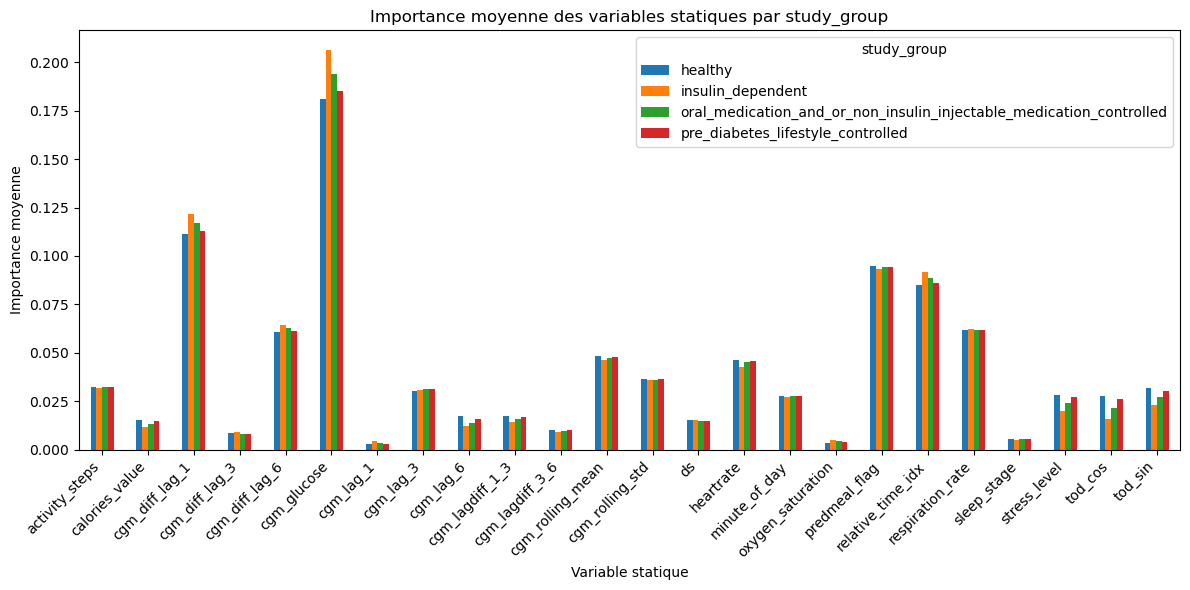

Figure sauvegardée : /home/yentlcollin/CGM/mambatf/Model_mambaTF/out_interpretability/static_importance_by_study_group_encoder.png


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = "/home/yentlcollin/CGM/mambatf/Model_mambaTF/out_interpretability/enc_importances.csv"
path = Path(csv_path)

out_path = path.with_name("static_importance_by_study_group_encoder.png")

plot_mean_importance_by_study_group(csv_path = csv_path, out_path = out_path)
